# Electricity Futures Price Variation — Machine Learning Project

- **Natacha Gaussin**  
- **Margaux Girona**  
- **Mathis Fourreau**

_ESILV — IF3_

## 1. Context & Motivation

Daily electricity prices are highly volatile and influenced by multiple factors:

- **Weather:** temperature, rain, wind  
- **Energy production:** nuclear, gas, hydro, coal, renewables  
- **Commodity markets:** gas, coal, carbon returns  
- **Cross-border flows** within Europe  
- **Geopolitical events** (e.g., Ukraine war)

These interactions make price modeling complex, especially at the country level.

---

## 2. Business Case

Electricity producers, traders, and risk managers rely on futures contracts to:

- Hedge price volatility  
- Manage financial risk  
- Plan production in advance  

The goal of this project is to **explain and model the daily variation of short-term baseload electricity futures for France and Germany**, focusing on explanation rather than classic time-series prediction.

---

## 3. Objective

**How can we explain and predict daily electricity futures price variations using weather, energy, and commodity data?**

- **Target:** `TARGET` = daily variation of 24h baseload futures (France or Germany)
- **Aim:** Capture non-linear effects, country heterogeneity, and key drivers
- **Metric:** Spearman correlation (ranking quality > exact magnitude)

##### **Spearman Correlation Formula**

$$\rho_s = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n\,(n^2 - 1)}$$

Where:  
- $ d_i $ = difference between the ranks of each pair  
- $ n $ = number of observations 
---

## 4. Dataset Overview

Source: ENS Challenge Data (RTE France & ENS Paris)

**Provided files:**
- `X_train.csv` — 1494 samples, 35 features  
- `Y_train.csv` — TARGET  
- `X_test.csv` — 654 samples  

**Feature categories (35 variables):**
- *Commodity returns:* GAS_RET, COAL_RET, CARBON_RET  
- *Weather:* temperature, rain, wind  
- *Production:* nuclear, gas, coal, hydro, solar, wind, lignite  
- *Usage:* consumption, residual load  
- *Cross-border:* FR↔DE exchanges  
- *Identifiers:* ID, DAY_ID, COUNTRY  

---





# Project Overview — Table of Contents

1. **Data Analysis**  
   - Univariate Analysis  
   - Multivariate Analysis  

2. **Feature Engineering**  
   - Threshold-Based Transformations  
   - Feature Selection  
   - Final Feature Sets (FR / DE)  

3. **Preprocessing & Modeling Framework**  
   - Data Transformation Pipeline  
   - Train/Test Split (FR & DE)  
   - Anti-Overfitting Strategy (CV, GridSearch, K-Fold)  

4. **Model Training**  
   - Baseline Models  
   - Models Covered in Class  
   - Models Outside Course Scope  
   - Deep Learning Models  

5. **Model Results & Insights**  
   - Cross-Country Performance (FR vs DE)  
   - Global Performance  
   - Bias–Variance Analysis  
   - Visual Comparison of Models  

6. **Conclusion**  
   - Summary of Learnings  
   - Limitations  
   - Ideas for Improvement / Future Work  


#### Libary importation

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Traitement de donnees
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
import itertools

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.base import clone
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#### Dataset Loading

In [ ]:
X = pd.read_csv("X_train_NHkHMNU.csv")
y = pd.read_csv("y_train_ZAN5mwg.csv")


df = pd.concat([X, y], axis=1)
df = df.drop(df.columns[-2], axis=1)
df = df.sort_values("DAY_ID")

In [3]:
df

DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
742        0      FR        0.048418       -0.465067       -0.079296   
1211       1      FR        0.966997        1.222131        0.331356   
1408       2      FR       -0.068972       -0.667390       -1.102015   
1468       2      DE       -0.068972       -0.667390       -1.102015   
329        3      FR       -0.134670       -0.834564       -1.051716   
...      ...     ...             ...             ...             ...   
1007    1212      FR       -0.046100       -0.520506       -0.270515   
986     1212      DE       -0.046100       -0.520506       -0.270515   
1465    1213      DE        1.407027        1.313254       -0.456126   
873     1213      FR        1.407027        1.313254       -0.456126   
1437    1215      FR        0.544810       -0.378158       -0.065993   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  \
742         0.079296            NaN       0.650577            NaN   
1211       -0.331356       0.405549       0.778627      -0.405549   
1408        1.102015      -1.080403       0.256736       1.080403   
1468        1.102015      -1.080403       0.256736       1.080403   
329         1.051716      -1.881881      -0.612133       1.881881   
...              ...            ...            ...            ...   
1007        0.270515      -0.137917      -0.789824       0.137917   
986         0.270515      -0.137917      -0.789824       0.137917   
1465        0.456126       0.333142      -0.069222      -0.333142   
873         0.456126       0.333142      -0.069222      -0.333142   
1437        0.065993            NaN       0.257829            NaN   

      FR_NET_IMPORT  ...   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP  \
742       -0.650577  ... -0.987968 -0.856204 -0.655528 -1.099226  0.279885   
1211      -0.778627  ... -0.370990 -0.497520 -1.184018 -1.465608  1.349212   
1408      -0.256736  ... -0.344600 -0.372156 -0.623041 -0.926064 -0.148950   
1468      -0.256736  ... -0.344600 -0.372156 -0.623041 -0.926064 -0.148950   
329        0.612133  ... -1.394561 -1.118297  0.244859  0.488650 -1.710888   
...             ...  ...       ...       ...       ...       ...       ...   
1007       0.789824  ... -0.039379 -0.237434  1.358211  1.123953 -0.707839   
986        0.789824  ... -0.039379 -0.237434  1.358211  1.123953 -0.707839   
1465       0.069222  ...       NaN       NaN       NaN       NaN       NaN   
873        0.069222  ...       NaN       NaN       NaN       NaN       NaN   
1437      -0.257829  ... -0.646163  0.738201 -0.903380 -0.882630 -0.247278   

       FR_TEMP   GAS_RET  COAL_RET  CARBON_RET    TARGET  
742   0.583874 -1.071996 -0.074767    0.798003  0.108953  
1211  0.231602  1.480313  0.931562    0.822047 -0.063369  
1408  0.641235  1.802550  1.140920    0.900434  2.575976  
1468  0.641235  1.802550  1.140920    0.900434  0.861270  
329  -0.951057  0.440121 -0.064550   -0.032756  0.068905  
...        ...       ...       ...         ...       ...  
1007 -0.308232  0.017778  0.072168   -0.160792 -0.425474  
986  -0.308232  0.017778  0.072168   -0.160792 -0.144320  
1465       NaN -0.103642 -0.633007    0.214805  0.147587  
873        NaN -0.103642 -0.633007    0.214805 -3.003988  
1437  0.755489  0.758698  0.078518    0.192945  0.029623  

[1494 rows x 35 columns]

# 1. Data Analysis

## Univariate Data Analysis

The first step of a data analysis is the univariate analysis.

The aim of this part is to study the behavior the each variable independently to better understand their distribution, features, quality...

This will be useful to gather meaningful information useful for feature engineering.

### Study of the target variable `TARGET`

The variable we are interested in is called in the dataset `TARGET`. It represents, the variation of the price of futures contracts of electricity in France and Germany.

In [4]:
# Descriptive statistics
print("Target variable's description : \n", df['TARGET'].describe(), "\n")

Target variable's description : 
 count    1494.000000
mean        0.089934
std         1.034582
min        -6.519268
25%        -0.219861
50%         0.000000
75%         0.269719
max         7.786578
Name: TARGET, dtype: float64 



In [5]:
# Histogram distribution

plt.figure(figsize=(8, 5))
sns.histplot(df["TARGET"], bins=50, kde=True, color="skyblue")
plt.title("Target variable's distribution")
plt.xlabel("Target variable")
plt.ylabel("Number")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observations**

This graph shows the distribution of the target variable. At first glance, the shape appears approximately Gaussian, with values relatively concentrated around 0.

However, the target variable description reveals that the target variable is not perfectly centered nor reduced:
- mean = 0.089934
- standard deviation = 1.034582

Although these values are close to the ideal (0 and 1), the slight deviations indicate that the distribution is only approximately standardized, not exactly.

### Differences between the French and German values

Let's study the difference between the price variation (target variable) of the french and german price :

In [6]:
# define two different datasets
df_fr = df[df["COUNTRY"] == "FR"].copy()
df_de = df[df["COUNTRY"] == "DE"].copy()

In [7]:
# Histogram distribution
plt.figure(figsize=(8, 5))

sns.histplot(df_fr["TARGET"], bins=50, kde=True, color="blue", label="France", alpha=0.5)
sns.histplot(df_de["TARGET"], bins=50, kde=True, color="red", label="Germany", alpha=0.5)

plt.title("Distribution of Target variable � France vs Germany")
plt.xlabel("Target variable")
plt.ylabel("Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Observations**

This graph displays the raw distribution of the target variable for France and Germany.
The french datasset shows a narrow, high-peaked distribution centered close to zero, indicating lower variance and fewer extreme values.
The german dataset's distribution is wider and flatter, showing higher dispersion and more outliers.

Overall, Germany�s values are more spread out, while France�s target variable is tightly clustered around the mean.

In [8]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df_fr["TARGET"], label="France", fill=True, alpha=0.4)
sns.kdeplot(df_de["TARGET"], label="Germany", fill=True, alpha=0.4)

plt.title("Normalized density of Target variable � France vs Germany")
plt.xlabel("Target variable")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Observations**

After normalization, both distributions are aligned around zero with comparable central peaks.
France still displays a more concentrated density, whereas Germany keeps a broader shape, although reduced compared to the raw data.

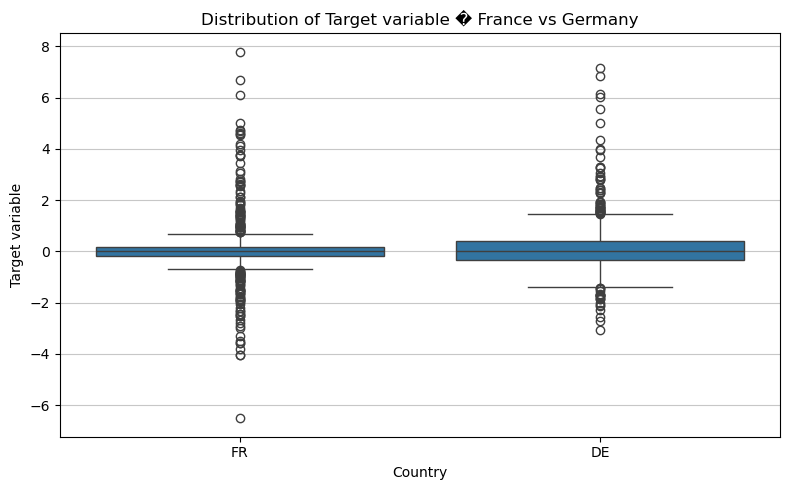

In [9]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df[df["COUNTRY"].isin(["FR", "DE"])],
    x="COUNTRY",
    y="TARGET"
)

plt.title("Distribution of Target variable � France vs Germany")
plt.xlabel("Country")
plt.ylabel("Target variable")
plt.grid(True, axis='y', alpha=0.7)
plt.tight_layout()
plt.show()


**Observations**

This graph represents thet bowplot of the french and german target variable. We can notice that the german's target variable has a wider spread and a larger interquartile range than the french dataset.

Overall, the French distribution is more compact, whereas the German dataset is more dispersed.

Moreover, both countries show **outliers**, but Germany displays more numerous mid-range outliers, while France shows more extreme ones.

**Why the French Dataset Is Less Dispersed than the German One - Energy Mix Differences**

A possible hypothesis for why the French target variable shows less dispersion than the German one is the difference in each country's energy mix.
France�s electricity production relies heavily on nuclear energy, which provides a stable and predictable output and is less sensitive to short-term external factors such as weather conditions (temperature, wind, sunlight).

Germany, on the other hand, depends much more on variable renewable sources such as wind (onshore and offshore) and solar power. These sources are more dependent on environmental conditions, leading to greater fluctuations in production.

This structural difference in energy mix generation could explain why the French dataset appears more concentrated, while the German one is more spread out.

**Outliers**

It is important to note these outliers, as they will need to be dealt with during the feature-engineering phase to improve model efficiency.

Let's take a look at one specific day :

In [11]:
df[df["DAY_ID"] == 2]

DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
1408       2      FR       -0.068972        -0.66739       -1.102015   
1468       2      DE       -0.068972        -0.66739       -1.102015   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  \
1408        1.102015      -1.080403       0.256736       1.080403   
1468        1.102015      -1.080403       0.256736       1.080403   

      FR_NET_IMPORT  ...  DE_RAIN   FR_RAIN   DE_WIND   FR_WIND  DE_TEMP  \
1408      -0.256736  ...  -0.3446 -0.372156 -0.623041 -0.926064 -0.14895   
1468      -0.256736  ...  -0.3446 -0.372156 -0.623041 -0.926064 -0.14895   

       FR_TEMP  GAS_RET  COAL_RET  CARBON_RET    TARGET  
1408  0.641235  1.80255   1.14092    0.900434  2.575976  
1468  0.641235  1.80255   1.14092    0.900434  0.861270  

[2 rows x 35 columns]

For a same given day (same day `DAY_ID`), the dataset gives the target variable for both France and Germany, meaning that there are two rows : one for each country. We can note that those twos rows have the exact same features' value (except for the country and the target variable).
This can be observed in the dataframe extract shown above, for example for `DAY_ID`=2.

So the features' value are duplicated into two rows when they have the same `DAY_ID`. Thus, we can make the following hypothesis :

If there are duplications for each day (one df_france, one Germany), we don't have to do two different univariate data analyses, one for each dataset as they would be the same.

Let's check that statement :

In [12]:
df_fr = df[df["COUNTRY"] == "FR"].sort_values("DAY_ID")
df_de = df[df["COUNTRY"] == "DE"].sort_values("DAY_ID")

In [13]:
print("Number of days for df_french's dataset : ", len(df_fr))
print("Number of days for German's dataset : ", len(df_de))

Number of days for df_french's dataset :  851
Number of days for German's dataset :  643


**Observations**

We can see that the french dataset is much larger than the german one. Thus it means there are singletons, and not only duplications. Thus we have to do two separate study for the french and german datasets.

**Conclusion**

This study highlights several key differences between the French and German datasets:
- Germany shows a wider distribution of the target variable
- France displays more extreme outliers.
- Some days contain duplicate feature rows (one per country).
- The French dataset contains more observations than the German one.

Based on these observations, we can conclude that::

**Going forward with the analysis and modelling, the dataset will be split into two independent subsets, one for each country.**

### French dataset Analysis

As we separated the dataset into two different datasets for each country, we don't need the `COUNTRY`variable anymore. We can drop this feature :

In [14]:
df_fr.drop(columns=["COUNTRY"], inplace=True)

#### Study of the missing values

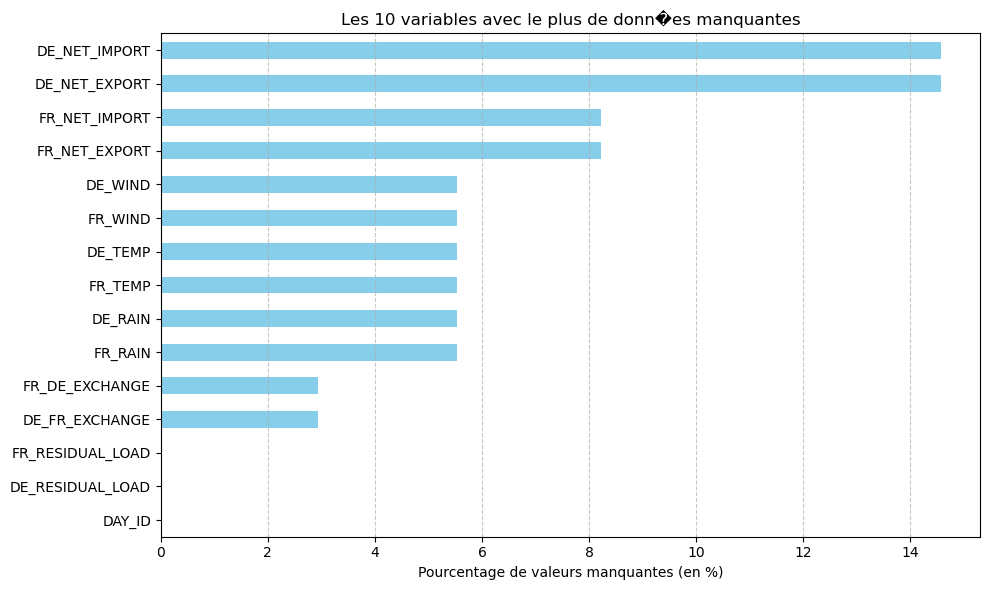

In [15]:
# percentage of missing values per column
missing_values = df_fr.isnull().mean() * 100

# top 15 of columns with the most missing values
top_15_colonnes = missing_values.sort_values(ascending=False).head(15)

# Horizontal barplot
plt.figure(figsize=(10, 6))
top_15_colonnes.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel("Pourcentage de valeurs manquantes (en %)")
plt.title("Les 10 variables avec le plus de donn�es manquantes")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Observations**

12 features have missing values whose percentage range from ~3% to ~14.5%.

For futures steps, we need find a way to eliminate those missing values. Here are the possibilities :
- drop the column
- apply median or mean
- drop the rows where there is a missing value
- Use a more advanced imputation method that replaces missing values in a way that preserves the relationships between variables

#### Study of the distribution of each features

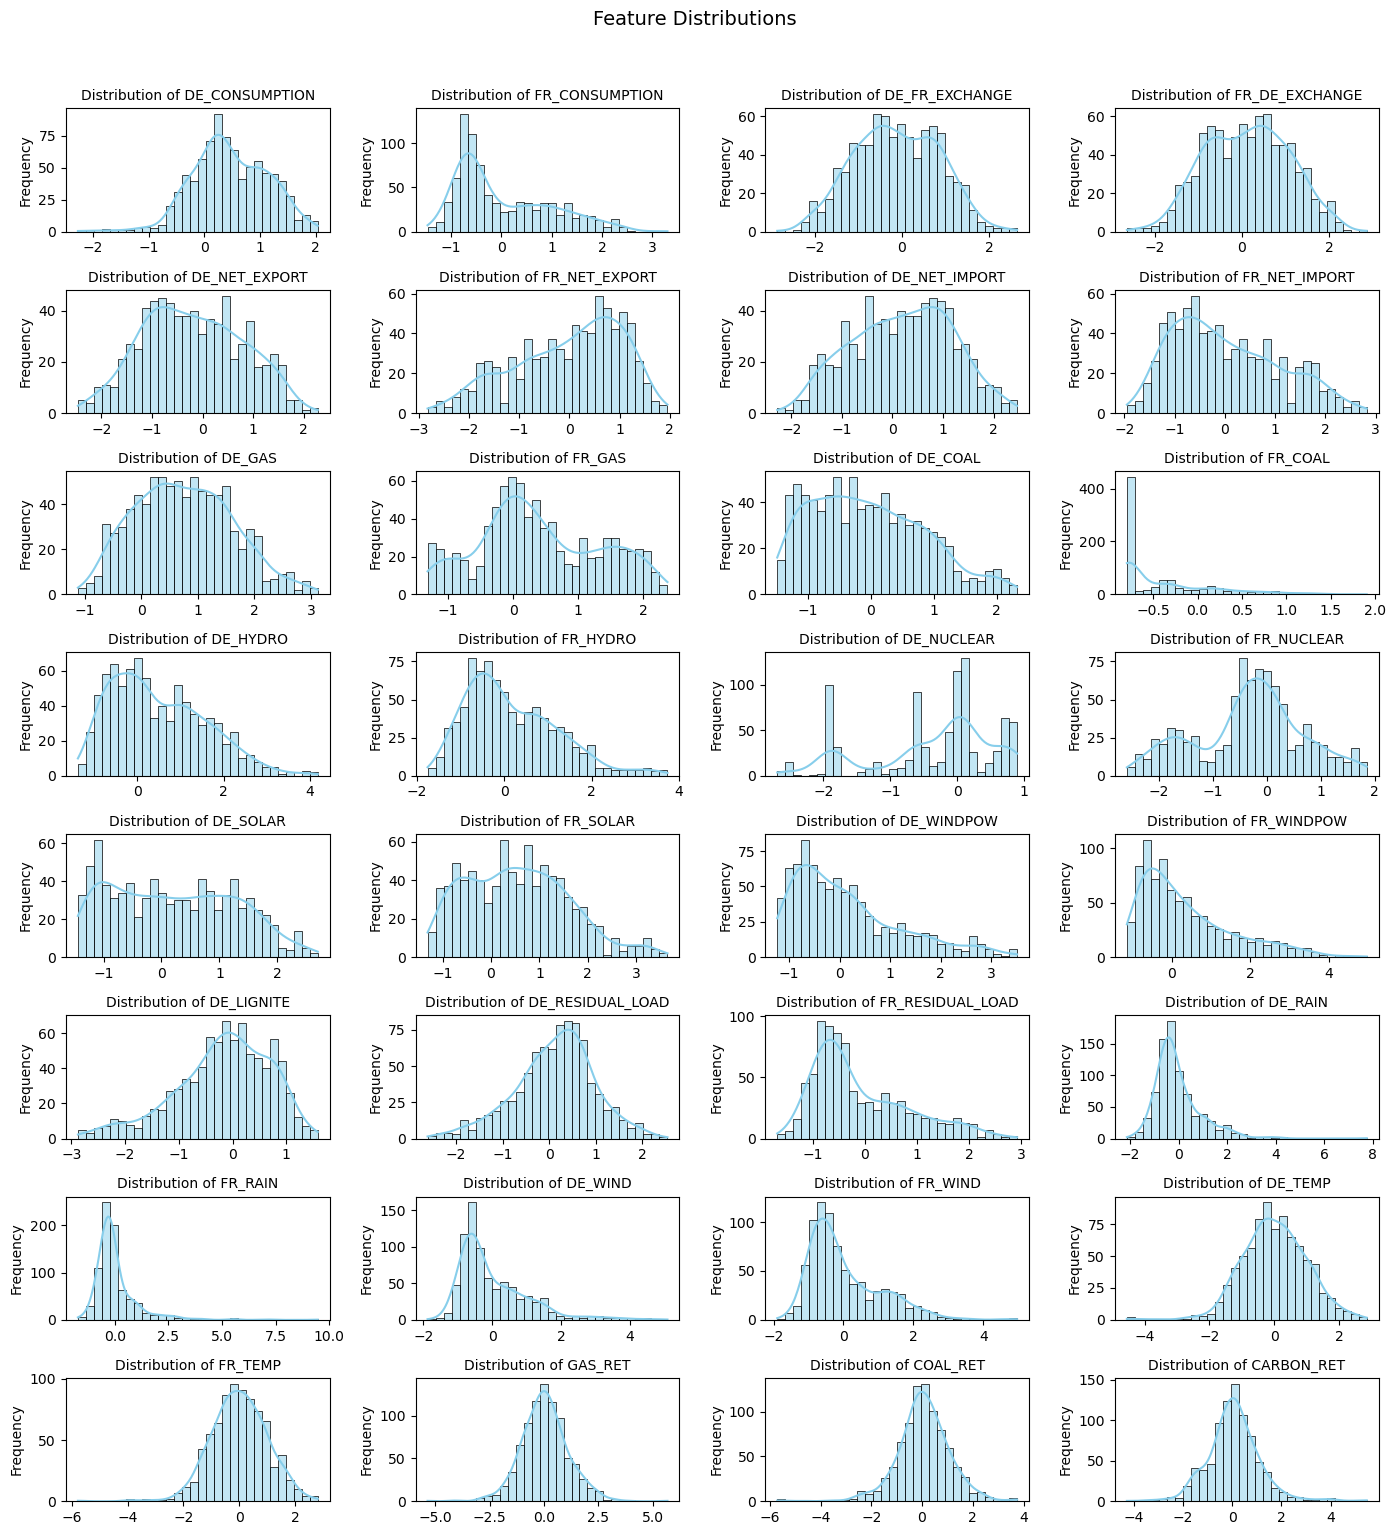

In [16]:
features = df_fr.drop(columns=["DAY_ID", "TARGET"]).columns

# Plot distributions
plt.figure(figsize=(14, 15))
for i, col in enumerate(features, 1):
    plt.subplot(8, 4, i)
    sns.histplot(df_fr[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.suptitle("Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Observations**

This reprensentation shows the distribution of each feature.

Most features appear to be centered around 0. We can also observe that a preprocessing step has already been applied: the majority of features fall within a small range (approximately from �5 to 5).
Indeed, some feature ranges are not consistent with their expected physical meaning. For example, the temperature for France (last graph on the left) only varies between �2 and 2, which is unusually narrow for real-world temperature data. This suggests that an additional transformation or normalization has been applied prior to this dataset.

In addition, we can note that the `FR_COAL` values are not diversified (graph on the third row and last column), most of the values are mostly the same. It could be interesting to drop this column in the feature engineering part as it will not provide any meaninful information. 

Moerover, 2 variables are noticeable : `FR_NUCLEAR` et `FR_GAS`. Their distributions exhibit three distinct clusters or threshold levels, as illustrated in the following graphs.

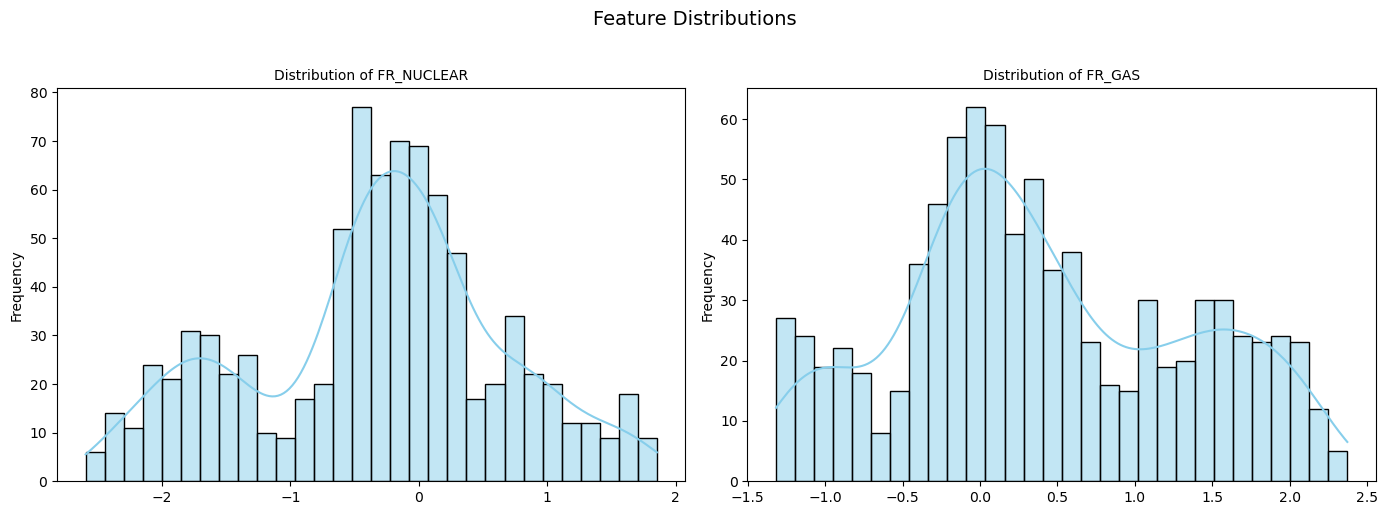

In [17]:
# Plot distributions
plt.figure(figsize=(14, 5))
for i, col in enumerate(["FR_NUCLEAR", "FR_GAS"], 1):
    plt.subplot(1, 2, i)
    sns.histplot(df_fr[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.suptitle("Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

The tiered structure observed in `FR_NUCLEAR` and `FR_GAS` likely reflects different operating regimes (baseline, reduced production, peak demand), which vary depending on the day and system conditions.

This point is supported by the article "Energy Transition in France" written by Badr Eddine Lebrouhi,Eric Schall, Bilal Lamrani and Chaibi Yassine. This article delves into the french plan to significantly increase the contribution of renewable energy in its energy mix.

### Duplicates

We first checked for duplicates in the initial dataset, which led us to split it into two separate subsets: one for France and one for Germany.

We now need to verify whether there are duplicates within each of these sub-datasets.

In [18]:
temp = df_fr.drop(columns=["DAY_ID"])
print(f"Number of duplicate rows in df_fr: {temp.duplicated().sum()}")

Number of duplicate rows in df_fr: 0


There are no duplicates in the french dataset.

### German Dataset analysis

In [19]:
df_de.drop(columns=["COUNTRY"], inplace=True)

#### Study of the missing values

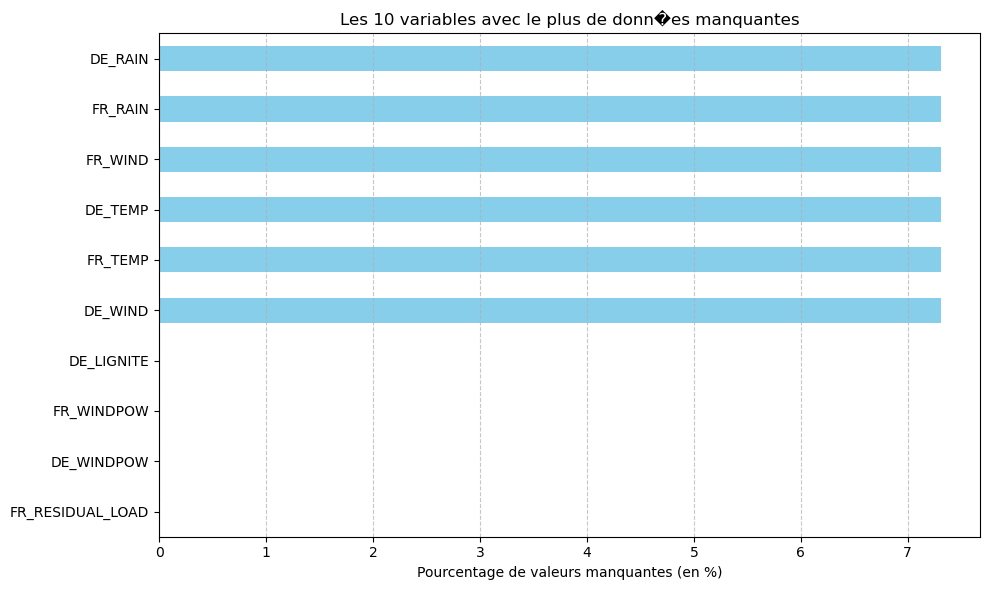

In [20]:
# percentage of missing values per column
missing_values = df_de.isnull().mean() * 100

# top 10 of columns with the most missing values
top_10_colonnes = missing_values.sort_values(ascending=False).head(10)

# Horizontal barplot
plt.figure(figsize=(10, 6))
top_10_colonnes.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel("Pourcentage de valeurs manquantes (en %)")
plt.title("Les 10 variables avec le plus de donn�es manquantes")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Observations**

6 features have missing values whose percentage are around 7.5%.

As with the french dataset, we need find a way to eliminate those missing values. Here are the possibilities :
- drop the column
- apply median or mean
- drop the rows where there is a missing value

#### Study of the distribution of each features

In [21]:
features = df_de.drop(columns=["DAY_ID", "TARGET"]).columns

# Plot distributions
plt.figure(figsize=(14, 15))
for i, col in enumerate(features, 1):
    plt.subplot(8, 4, i)
    sns.histplot(df_de[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.suptitle("Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Observations**

Since the French and German datasets share many identical feature values, the overall feature distributions are very similar in both cases. We can therefore draw the same conclusions as for the French dataset:
- prior preprocessing has clearly been applied to the feature values
- `FR_COAL` variable shows very limited variability
- distinct clusters are observed for `FR_NUCLEAR` and `FR_GAS`

#### Duplicates

In [22]:
temp = df_de.drop(columns=["DAY_ID"])
print(f"Number of duplicate rows in df_de: {temp.duplicated().sum()}")

Number of duplicate rows in df_de: 0


There are no duplicates.

In [24]:
X = pd.read_csv("X_train_NHkHMNU.csv")
y = pd.read_csv("y_train_ZAN5mwg.csv")

df = pd.concat([X, y], axis=1)

df = df.drop(df.columns[-2], axis=1)

In [25]:
df_fr = df[df["COUNTRY"] == "FR"]
df_de = df[df["COUNTRY"] == "DE"]

In [26]:
df.columns

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')

## Multivariate Analysis

**The aim of this part is to understand the relationships between the features.**  
This is important to consider the different types of interactions between variables (linear, non-linear, interactions, or even effects that change beyond a certain threshold).  
For this purpose, we will follow the methodology below:


1) **General overview of the correlations between features**

This section is a necessary step to gain an initial understanding of the different links between features.  
We will identify:
- highly correlated features,  
- features with almost no association with the target,  
- differences between correlations with the French and German targets.

All these information will be very important, especially for the features engineering step.

2) **Finding non linear relationship**
This step is also very important for the features engineering part, indeed we will try to capture some more complex link between features and target. We will do this in two different approachs:
- Looking for thresholds above which a meaningful association emerges.
Supported by research papers mentioned in the next section, we investigate whether certain feature�target associations become significant only beyond specific ranges of values.

- Studying how combinations of several features can explain the price.
We examine whether multi-feature interactions capture additional information and provide better explanatory power than individual features alone.

### **General overview of the correlations between features**

#### Pearson Correlation

First we will look at the pearson correlations between the different variables. This correlation measure captures the linear relationship between two variables.

#### **France**

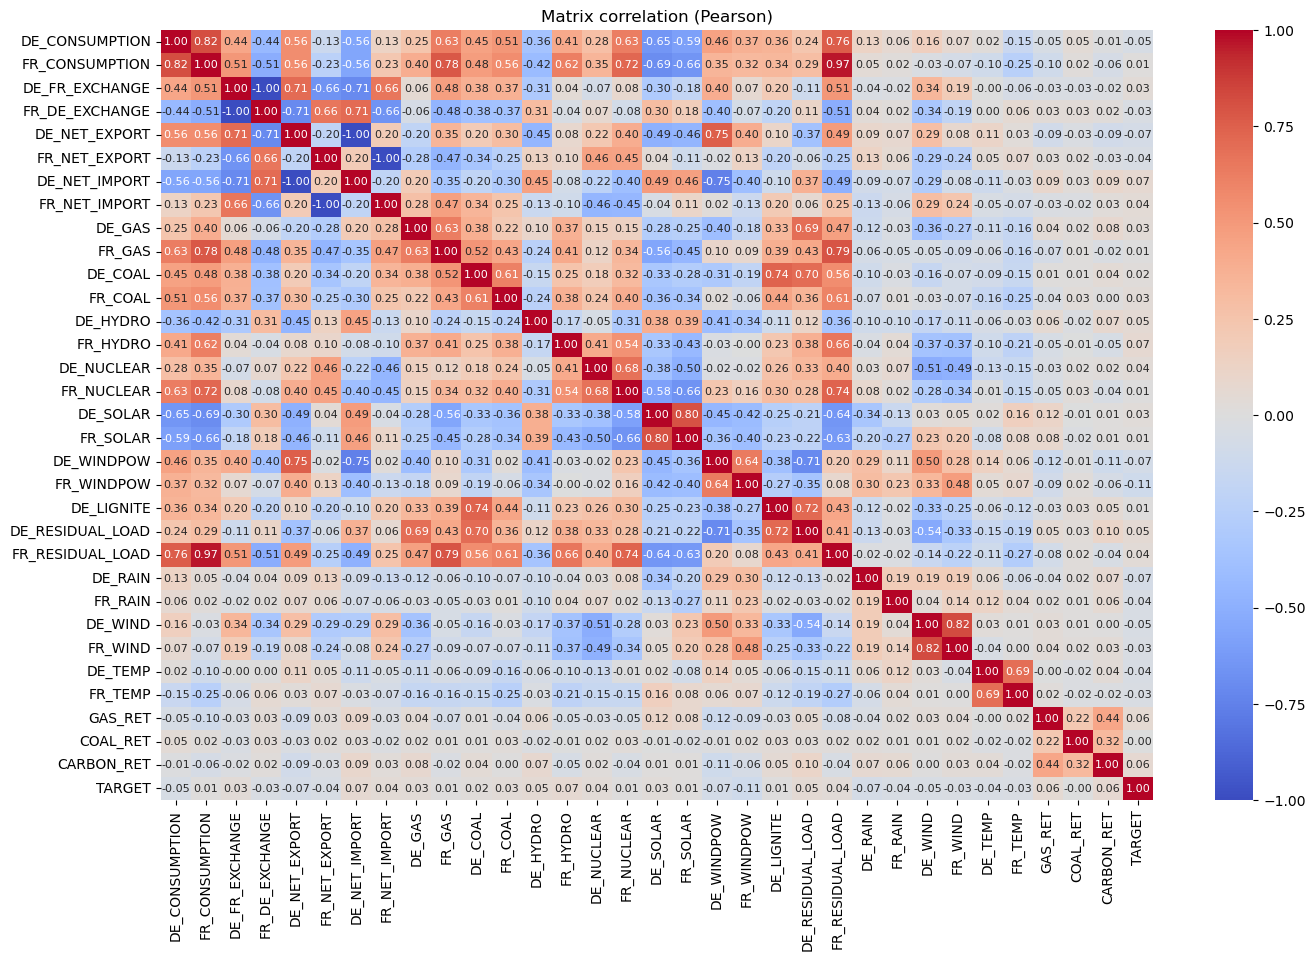

In [27]:
df_fr_continuous = df_fr.drop(columns = ["COUNTRY", "DAY_ID"])

corr_pearson_fr = df_fr_continuous.corr(method='pearson')

plt.figure(figsize=(16, 10))
sns.heatmap(corr_pearson_fr, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation (Pearson)")
plt.show()


From this first view, several point are important:
- First the Target has very low pearson correlations with the other variable, that will make the prediction relevant, especially with model like linear regression.
- Some variable are just the opposite of each other, with correlations of -1, it's logical since we have variable like FR_DE_EXCHANGE and DE_FR_EXCHANGE, we will remove some of to avoid multicolinearity.
- Except the variable which are pefectly negatively correlated, only two other variable are highly correlated(abs(correlation) > 0.85), it's FR_RESIDUAL_LOAD which is the electricity consumed after the use of all renouvable energy, with FR_CONSUMPTION which is total electicity consumed. That's a big difference comparing to the German case where the two correspondant features have only a correlation of 0.24.
- More generaly the french and deutch variable have not the same correlations, that indicate the two system work differently.

#### **Germany**

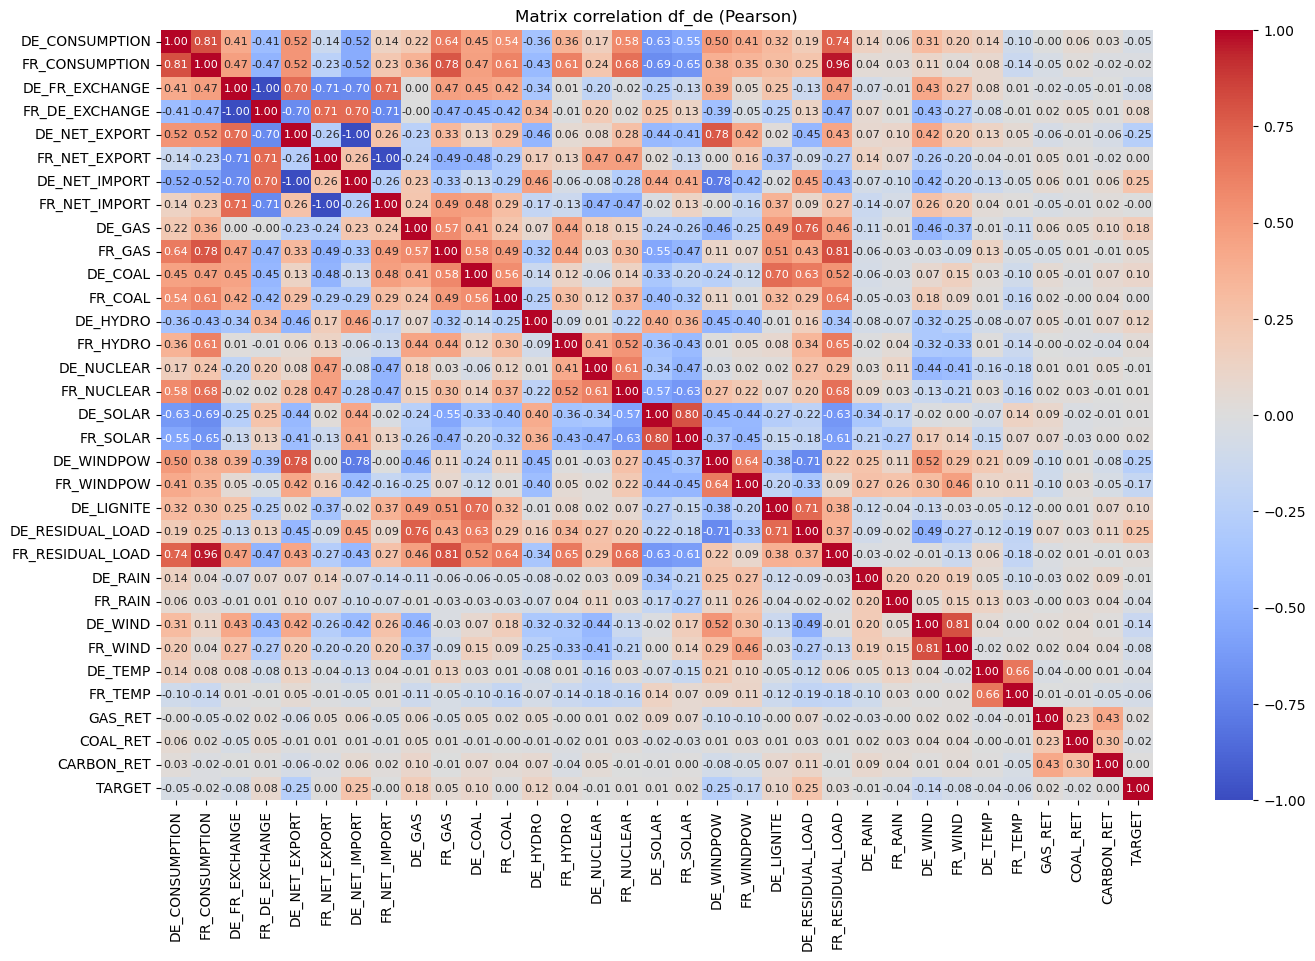

In [28]:
df_de_continuous = df_de.drop(columns = ["COUNTRY", "DAY_ID"])

corr_pearson_de = df_de_continuous.corr(method='pearson')

plt.figure(figsize=(16, 10))
sns.heatmap(corr_pearson_de, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation df_de (Pearson)")
plt.show()

The correlations between the variable are pretty from what we had with the french dataset, however in this dataframe the Target is not the same (it's now the price of the deutch electricity). The correlations between the different features and the target are in general higher than in the df_fr, especially with the deutsh variable (DE_NET_IMPORT, DE_WINDPOW,...) which seems pretty logical. These observations really renforced the idea that the french and german prices can't be explain in the same way, with the same variables. It coud be interesting to have two different models.

#### Spearman Correlation

We recall that our metric to optimise is the Spearman correlation, that mesure the relations between the order of our predictions and the order of the true values. It's why it's interesting to check also the spearman correlations between the variables.

#### **France**

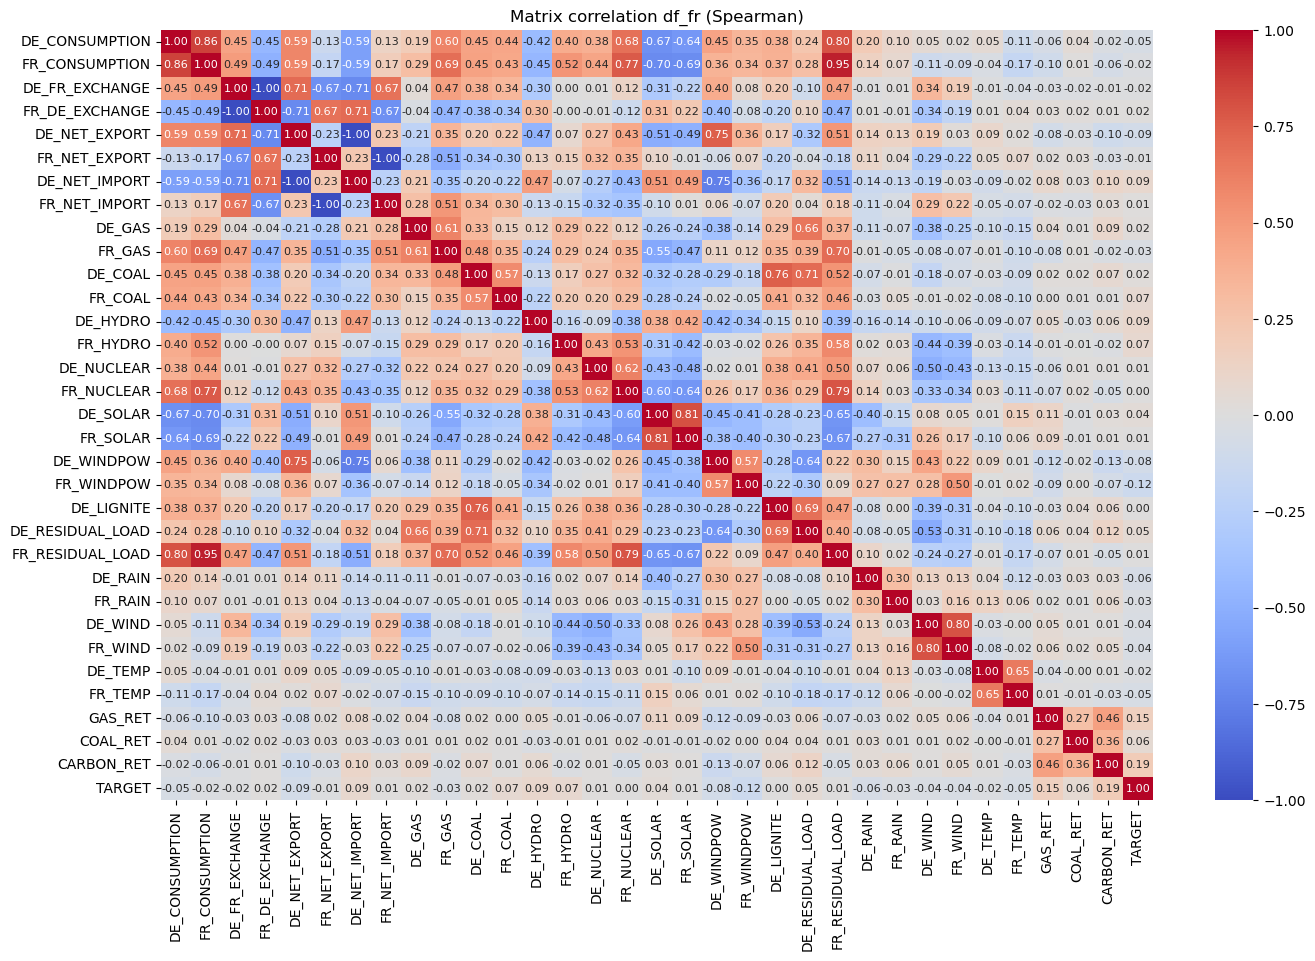

In [29]:
corr_spearman_fr = df_fr_continuous.corr(method='spearman')
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman_fr, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation df_fr (Spearman)")
plt.show()


In [30]:
corr_target = corr_spearman_fr["TARGET"]
selected_features_fr = corr_target[abs(corr_target) > 0.08].iloc[:-1]
print(selected_features_fr)

DE_NET_EXPORT   -0.085175
DE_NET_IMPORT    0.085175
DE_HYDRO         0.087350
DE_WINDPOW      -0.080487
FR_WINDPOW      -0.121530
GAS_RET          0.148956
CARBON_RET       0.191809
Name: TARGET, dtype: float64


In [31]:
print(f"Valeur absolue moyenne corr�lation Pearson featutes/targets: {abs(corr_pearson_fr.iloc[-1].iloc[:-1]).mean()}")
print(f"Valeur absolue moyenne corr�lation Spearman featutes/targets: {abs(corr_spearman_fr.iloc[-1].iloc[:-1]).mean()}")

Valeur absolue moyenne corr�lation Pearson featutes/targets: 0.04136248788460518
Valeur absolue moyenne corr�lation Spearman featutes/targets: 0.04809161801876165


we observe correlations between variables and target that are a little bit higher comparing to the pearson correlations, notably with GAS_RET or CARBON_RET, that show  that some non-linear relations exist.

#### **Germany**

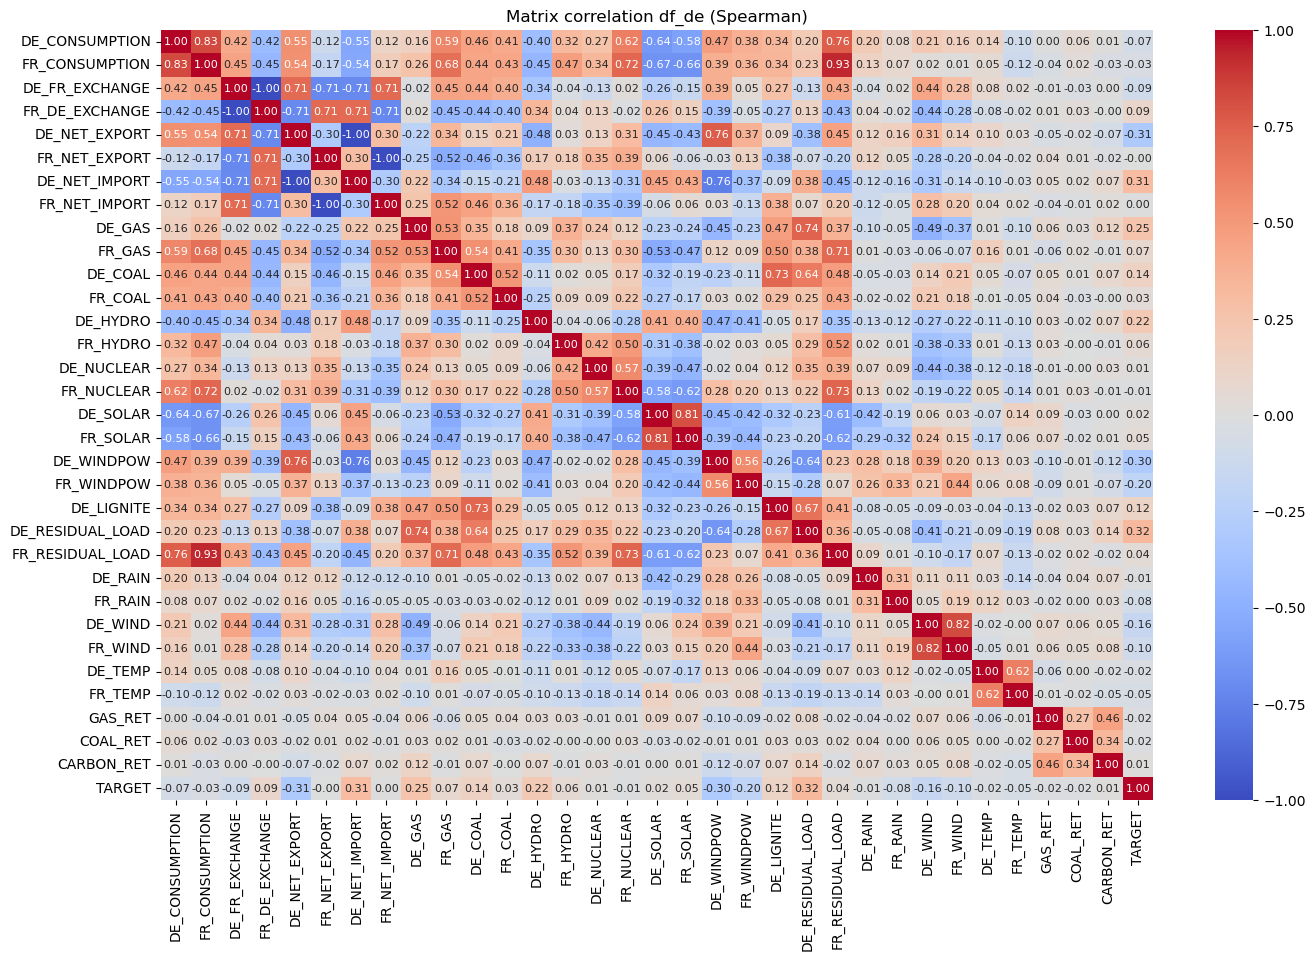

In [32]:
corr_spearman_de = df_de_continuous.corr(method='spearman')
plt.figure(figsize=(16, 10))
sns.heatmap(corr_spearman_de, cmap='coolwarm', center=0, annot=True,fmt=".2f", annot_kws={"size": 8})
plt.title("Matrix correlation df_de (Spearman)")
plt.show()

In [33]:
corr_target_de = corr_spearman_de["TARGET"]
selected_features_de = corr_target_de[abs(corr_target_de) > 0.12].iloc[:-1]
print(selected_features_de)

DE_NET_EXPORT      -0.306204
DE_NET_IMPORT       0.306204
DE_GAS              0.253410
DE_COAL             0.142054
DE_HYDRO            0.217900
DE_WINDPOW         -0.300933
FR_WINDPOW         -0.199820
DE_LIGNITE          0.124605
DE_RESIDUAL_LOAD    0.324335
DE_WIND            -0.162500
Name: TARGET, dtype: float64


In [34]:
print(f"Valeur absolue moyenne corr�lation Pearson featutes/targets: {abs(corr_pearson_de.iloc[-1].iloc[:-1]).mean()}")
print(f"Valeur absolue moyenne corr�lation Spearman featutes/targets: {abs(corr_spearman_de.iloc[-1].iloc[:-1]).mean()}")

Valeur absolue moyenne corr�lation Pearson featutes/targets: 0.07813471622953036
Valeur absolue moyenne corr�lation Spearman featutes/targets: 0.1015791993138224


That's the same constat for the deutsch dataframe, but with higher correlations coefficient, and again that's the deutsh variable that have the highest correlations with the target (that's logical however, in df_fr the same observation can't be done).

### **Finding non-linear relations between features and Target**

### Looking for thresholds

##### **Searching of thresholds for df_fr**

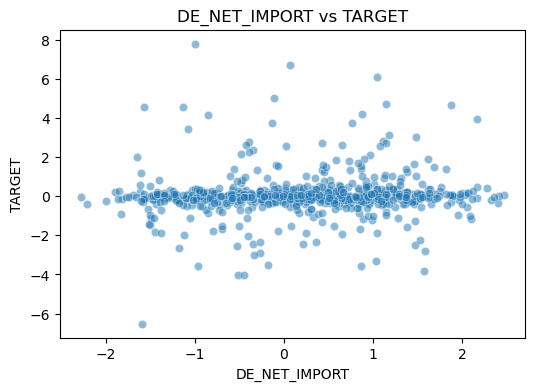

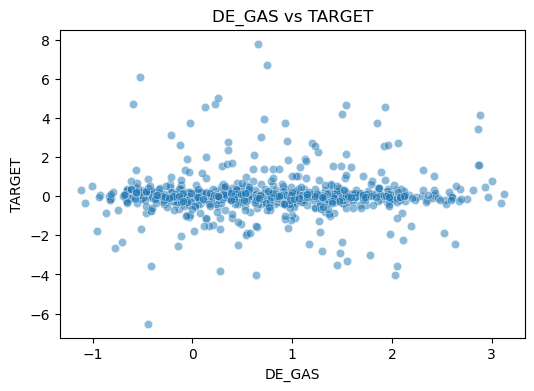

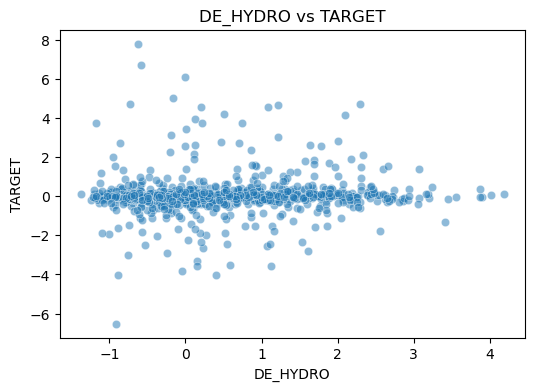

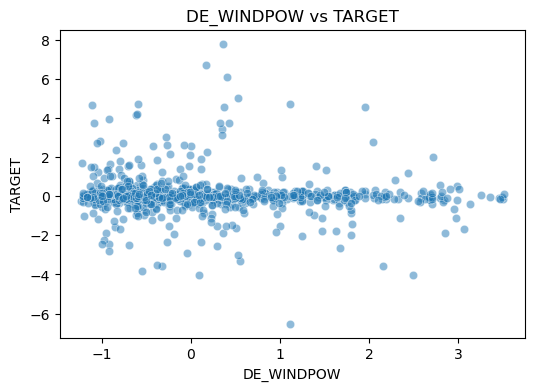

In [35]:
features = ["DE_NET_IMPORT", "DE_RESIDUAL_LOAD", "DE_GAS", "DE_HYDRO", "DE_WINDPOW"]

for feat in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_fr[feat], y=df_fr["TARGET"], alpha=0.5)
    plt.title(f"{feat} vs TARGET")
    plt.show()



We can first observe very poor relationship, furthermore there are a lot of outliers that make the visualisations (this observation is the same for all the features not only the ones that are presented here) very noisy and the interpretation very difficult. It's why we will observe the rolling median, and try to observe some visible values above which the median seems to have a solid relation with the price. We observe the median and not the mean because we search to optimize the spearman correlations so the order of our predictions with the true values.

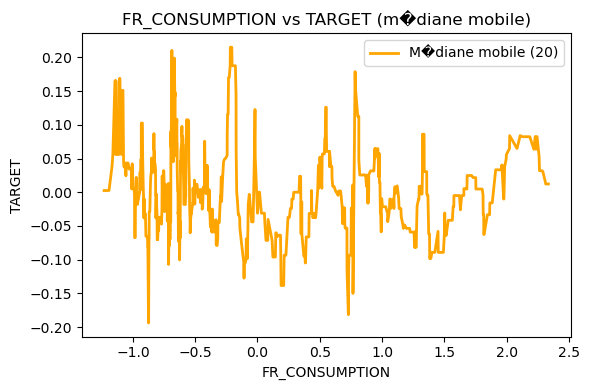

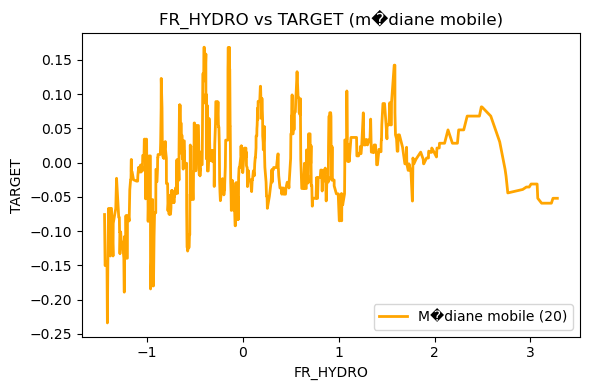

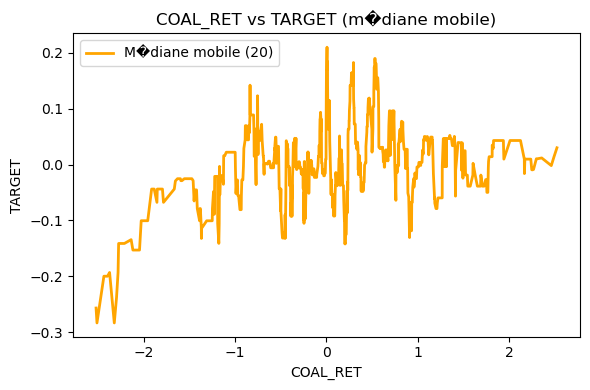

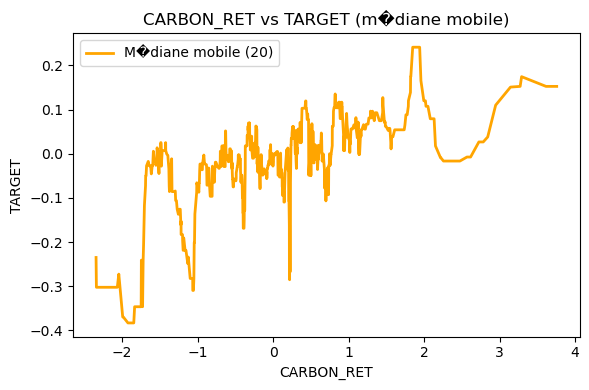

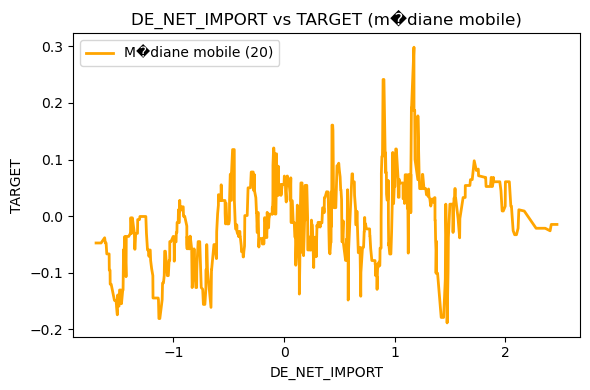

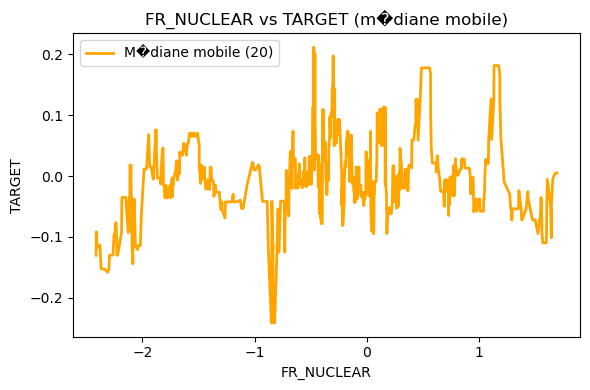

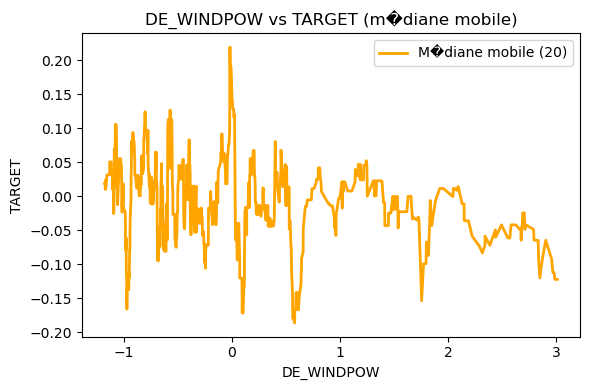

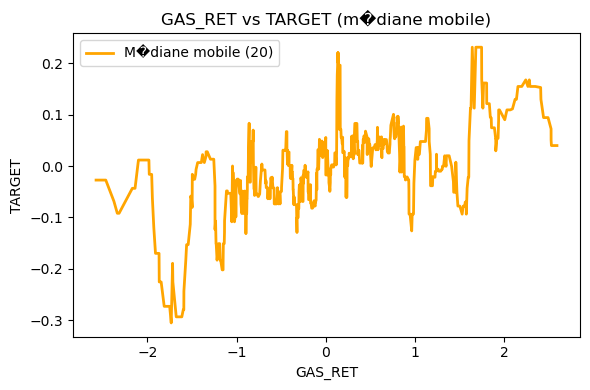

In [36]:
window = 20
features_thresholds = ["FR_CONSUMPTION", "DE_FR_EXCHANGE", "FR_HYDRO","COAL_RET", "CARBON_RET", "DE_NET_IMPORT", "FR_NUCLEAR", "DE_WINDPOW", "GAS_RET"]

for feat in features_thresholds:
    plt.figure(figsize=(6,4))
    sorted_df = df_fr[[feat, "TARGET"]].sort_values(by=feat)
    
    # Remplace rolling mean par rolling median
    rolling_median = sorted_df["TARGET"].rolling(window=window, center=True).median()
    
    plt.plot(sorted_df[feat], rolling_median, color="orange", linewidth=2, label=f'M�diane mobile ({window})')
    plt.title(f"{feat} vs TARGET (m�diane mobile)")
    plt.xlabel(feat)
    plt.ylabel("TARGET")
    plt.legend()
    plt.tight_layout()
    plt.show()

From these last visualisations we remark several possible theshold.
- FR_CONSUMPTION (positive correlation for FR_CONSUMPTION > 1.5)
- DE_FR_EXCHANGE (positive correlation for DE_FR_EXCHANGE > 1.7)
- FR_HYDRO (positive for < -0.4)
- COAL_RET (Positive correlation for COAL_RET < -0.8)
- CARBON_RET (Positive correlation in [-2, 2])
- DE_NET_IMPORT (Positive correlation for DE_NET_IMPORT < 1.2)
- FR_NUCLEAR (Positive correlation for FR_NUCLEAR < -1.8)
- DE_WINDPOW (Negative Correlation for DE_WINDPOW > 1.1)
- GAS_RET (Positive correlation for GAS_RET in [-1.8, 1.6])


The goal of this code is to evaluate how threshold filtering on specific variables affects their Spearman correlation with the target (TARGET) for France (df_fr).

In [ ]:

thresholds = {"FR_CONSUMPTION": (1.5, None), "DE_FR_EXCHANGE": (1.7, None), "FR_HYDRO": (None, -0.4), "COAL_RET": (None, -0.8),
    "CARBON_RET": (-2, 2),  "DE_NET_IMPORT": (None, 1.2),  "FR_NUCLEAR": (None, -1.8), "DE_WINDPOW": (1.1, None), "GAS_RET": (-1.8, 1.8)}
spearman_results = {}

for var, (low, high) in thresholds.items():
    if low is not None and high is not None:
        df_sel = df_fr[(df_fr[var] >= low) & (df_fr[var] <= high)]
    elif low is not None:
        df_sel = df_fr[df_fr[var] >= low]
    elif high is not None:
        df_sel = df_fr[df_fr[var] <= high]
    else:
        df_sel = df_fr.copy()

    n_filtered = len(df_sel)
    corr_global = df_fr[[var, "TARGET"]].corr(method="spearman").iloc[0, 1]
    corr_filtered = ( df_sel[[var, "TARGET"]].corr(method="spearman").iloc[0, 1])

    spearman_results[var] = {"Spearman_filtered": corr_filtered,"Spearman_global": corr_global,"n_filtered": n_filtered}

results_df = pd.DataFrame(spearman_results).T
results_df = results_df[["Spearman_filtered", "Spearman_global", "n_filtered"]]
results_df = results_df.sort_values(by="Spearman_filtered", ascending=False)

print(" Spearman correlations (filtered vs global) ")
display(results_df)


 Spearman correlations (filtered vs global) 


Spearman_filtered  Spearman_global  n_filtered
COAL_RET                 0.198922         0.057616       132.0
CARBON_RET               0.178944         0.191809       802.0
GAS_RET                  0.138268         0.148956       767.0
FR_NUCLEAR               0.124255         0.004077        91.0
FR_HYDRO                 0.119733         0.071709       305.0
FR_CONSUMPTION           0.105804        -0.020299        85.0
DE_FR_EXCHANGE           0.094505        -0.015005        14.0
DE_NET_IMPORT            0.094094         0.085175       614.0
DE_WINDPOW              -0.102247        -0.080487       159.0

### Conclusion on the thresholds effects for df_fr
- **Credible threshold effects**: : `COAL_RET`, `FR_CONSUMPTION`, `FR_NUCLEAR`, maybe `FR_HYDRO`. Indeed we have an important increasing of the Spearman correlation comparing to the correlation for any value, further more thiese observations are true for an "important" number of observations.
- **No clear threshold effect**: `CARBON_RET`, `GAS_RET`, `DE_NET_IMPORT`.  
  Filtered and global correlations are similar
- For `DE_FR_EXCHANGE` number of observations respecting the theshold is to limited, we can't really interprate the result.

### **Searching of thresholds for df_de**

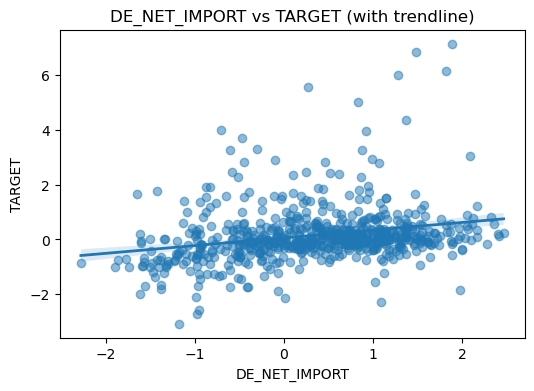

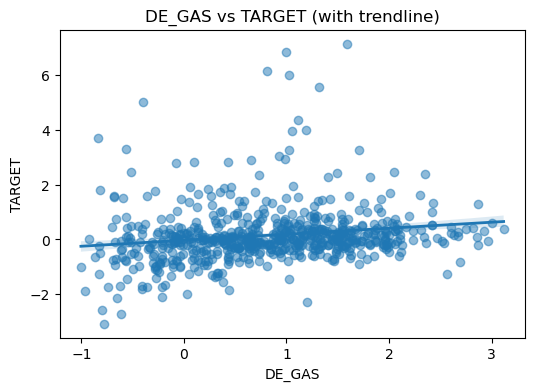

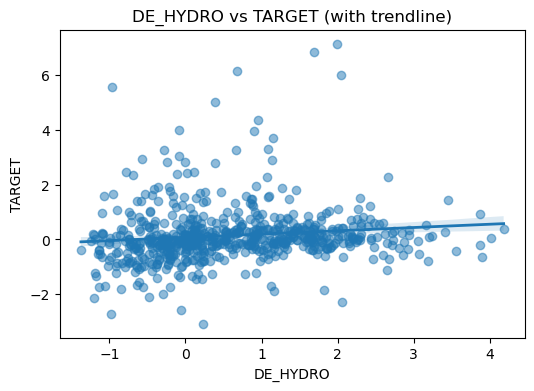

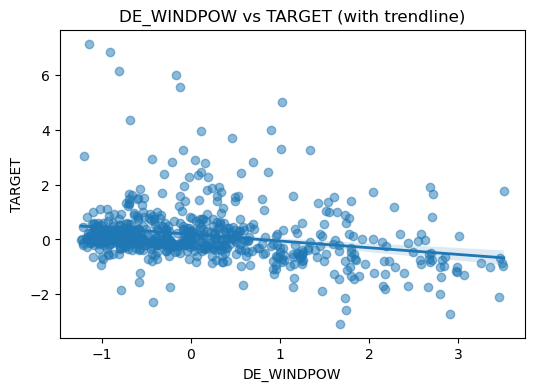

In [38]:
features = ["DE_NET_IMPORT", "DE_RESIDUAL_LOAD", "DE_GAS", "DE_HYDRO", "DE_WINDPOW"]
for feat in features:
    plt.figure(figsize=(6,4))
    sns.regplot(
        x=df_de[feat],
        y=df_de["TARGET"],
        scatter_kws={"alpha": 0.5},
        line_kws={"linewidth": 2}
    )
    plt.title(f"{feat} vs TARGET (with trendline)")
    plt.show()


There are more visible relationship with the deutsh target. We will also check for potential tresholds effects.

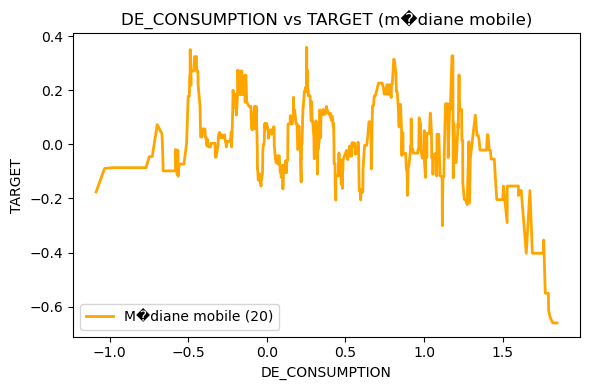

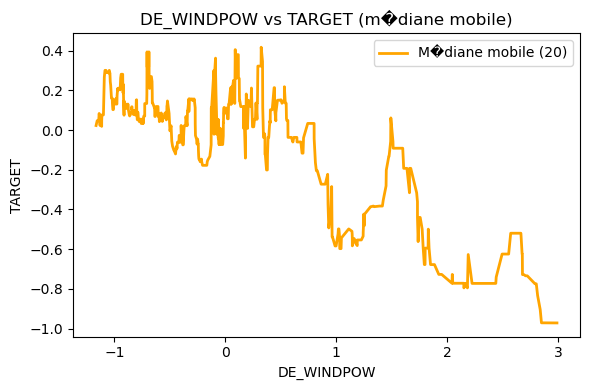

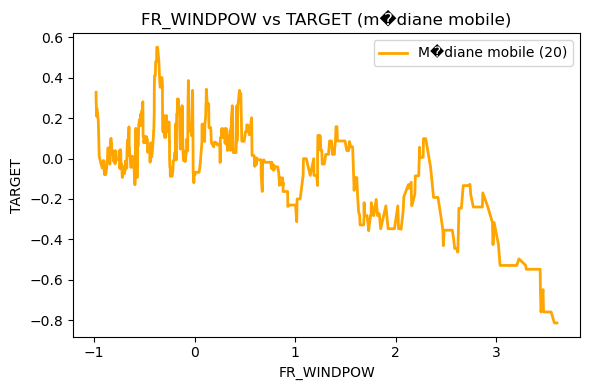

In [39]:
window = 20
features_thresholds = ["DE_CONSUMPTION", "DE_NET_EXPORT", "DE_NET_IMPORT", "DE_HYDRO", "DE_WINDPOW", "FR_WINDPOW", "DE_WIND"]
for feat in features_thresholds:
    plt.figure(figsize=(6,4))
    sorted_de = df_de[[feat, "TARGET"]].sort_values(by=feat)
    
    # Remplace rolling mean par rolling median
    rolling_median = sorted_de["TARGET"].rolling(window=window, center=True).median()
    
    plt.plot(sorted_de[feat], rolling_median, color="orange", linewidth=2, label=f'M�diane mobile ({window})')
    plt.title(f"{feat} vs TARGET (m�diane mobile)")
    plt.xlabel(feat)
    plt.ylabel("TARGET")
    plt.legend()
    plt.tight_layout()
    plt.show()

From these last visualisations we remark several possible theshold.
- DE_CONSUMPTION (positive correlation for DE_CONSUMPTION > 1.2)
- DE_NET_EXPORT (negative correlation for DE_NET_EXPORT > -0.45)
- DE_NET_IMPORT (positive for DE_NET_IMPORT < 0.45)
- DE_HYDRO (positive correlation for DE_HYDRO < 0.7)
- DE_WINDPOW (negative correlation for DE_WINDPOW > 0.3)
- FR_WINDPOW (negative correlation for FR_WINDPOW > 0.45)
- DE_WIND (negative correlation for DE_WIND < 2)

In [40]:

thresholds_de = {
    "DE_CONSUMPTION": (1.2, None),
    "DE_NET_EXPORT": (-0.45, None),
    "DE_NET_IMPORT": (None, 0.45),
    "DE_HYDRO": (None, 0.7),
    "DE_WINDPOW": (0.3, None),
    "FR_WINDPOW": (0.45, None),
    "DE_WIND": (0.25, 2)
}

spearman_results_de = {}

for var, (low, high) in thresholds_de.items():

    if low is not None and high is not None:
        df_sel = df_de[(df_de[var] >= low) & (df_de[var] <= high)]
    elif low is not None:
        df_sel = df_de[df_de[var] >= low]
    elif high is not None:
        df_sel = df_de[df_de[var] <= high]
    else:
        df_sel = df_de.copy()

    n_filtered = len(df_sel)

    corr_global = df_de[[var, "TARGET"]].corr(method="spearman").iloc[0, 1]
    corr_filtered = df_sel[[var, "TARGET"]].corr(method="spearman").iloc[0, 1]

    spearman_results_de[var] = {
        "Spearman_filtered": corr_filtered,
        "Spearman_global": corr_global,
        "n_filtered": n_filtered
    }

results_df_de = pd.DataFrame(spearman_results_de).T
results_df_de = results_df_de[["Spearman_filtered", "Spearman_global", "n_filtered"]]
results_df_de = results_df_de.sort_values(by="Spearman_filtered", ascending=False)

print(" Spearman correlations (filtered vs global, DE dataset) ")
display(results_df_de)



 Spearman correlations (filtered vs global, DE dataset) 


Spearman_filtered  Spearman_global  n_filtered
DE_NET_IMPORT            0.363736         0.306204       336.0
DE_HYDRO                 0.210295         0.217900       368.0
DE_WIND                 -0.176221        -0.162500       212.0
DE_CONSUMPTION          -0.178018        -0.071736        86.0
FR_WINDPOW              -0.229371        -0.199820       247.0
DE_NET_EXPORT           -0.363736        -0.306204       336.0
DE_WINDPOW              -0.391259        -0.300933       225.0

From this we will keep the different thresholds:
- DE_NET_IMPORT < 0.45
- DE_CONSUMPTION > 1.2
- DE_NET_EXPORT > -0.45
- DE_WINDPOW > 0.3


### **Feature Combination Analysis**

The goal of this part is to test if the combination of some features could explain better the target than the features alone.

##### **Combination of features for the french dataset**

We recall the features having the best spearman correlation wit the target

In [41]:
print(selected_features_fr.sort_values(key=lambda x: 1/x.abs()))

CARBON_RET       0.191809
GAS_RET          0.148956
FR_WINDPOW      -0.121530
DE_HYDRO         0.087350
DE_NET_EXPORT   -0.085175
DE_NET_IMPORT    0.085175
DE_WINDPOW      -0.080487
Name: TARGET, dtype: float64


To avoid testing arbitrary combination of variabes, we will test every combination of two or three variables.

In [42]:
features = [
    col for col in df.columns 
    if col not in ["TARGET", "COUNTRY", "DAY_ID"]
]


def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred, nan_policy='omit').correlation


**Combinations of 2 variables**

In [43]:
results = []
target = df_fr["TARGET"]
n = len(features)

for i in range(n):
    for j in range(i+1, n): 

            f1 = features[i]
            f2 = features[j]

            combo_name = f"{f1} x {f2}"

            combo_values = df_fr[f1] * df_fr[f2]

            corr = spearman_corr(combo_values, target)
            results.append((combo_name, corr))

best_interaction_fr2 = sorted(results, key=lambda x: abs(x[1]), reverse=True)

pd.DataFrame(best_interaction_fr2, columns=["interaction", "spearman"]).head(10)

interaction  spearman
0            FR_COAL x CARBON_RET -0.124437
1        DE_CONSUMPTION x GAS_RET  0.120647
2            FR_COAL x FR_WINDPOW  0.117984
3           DE_HYDRO x DE_WINDPOW -0.099609
4               FR_GAS x FR_SOLAR -0.099172
5            FR_COAL x DE_WINDPOW  0.097420
6               FR_COAL x GAS_RET -0.096017
7  FR_CONSUMPTION x FR_NET_EXPORT -0.095953
8  FR_CONSUMPTION x FR_NET_IMPORT  0.095953
9         DE_NET_EXPORT x FR_COAL  0.092507

We constat some interesting interaction, but it's pretty difficult to understand why these combination have these spearman correlations wit the target.

**Combinations of 3 variables**

In [44]:
n = len(features)

for i in range(n):
    for j in range(i+1, n):    
        for k in range(j+1, n): 

            f1 = features[i]
            f2 = features[j]
            f3 = features[k]

            combo_name = f"{f1} x {f2} x {f3}"

            combo_values = df_fr[f1] * df_fr[f2] * df_fr[f3]

            corr = spearman_corr(combo_values, target)
            results.append((combo_name, corr))

best_interaction_fr3 = sorted(results, key=lambda x: abs(x[1]), reverse=True)

pd.DataFrame(best_interaction_fr3, columns=["interaction", "spearman"]).head(10)

interaction  spearman
0      FR_NET_EXPORT x FR_NET_IMPORT x CARBON_RET -0.168152
1      DE_NET_EXPORT x DE_NET_IMPORT x CARBON_RET -0.163859
2                  DE_WIND x FR_WIND x CARBON_RET  0.163449
3         DE_NET_EXPORT x DE_NET_IMPORT x GAS_RET -0.152080
4         DE_NET_EXPORT x DE_WINDPOW x FR_WINDPOW -0.148061
5         DE_NET_IMPORT x DE_WINDPOW x FR_WINDPOW  0.148061
6         DE_NET_EXPORT x DE_WINDPOW x CARBON_RET  0.145581
7         DE_NET_IMPORT x DE_WINDPOW x CARBON_RET -0.145581
8  FR_CONSUMPTION x FR_RESIDUAL_LOAD x CARBON_RET  0.143675
9    DE_FR_EXCHANGE x FR_DE_EXCHANGE x CARBON_RET -0.137473

We observe very interesting relationship with the target, we recall that for the french dataset only 1 feature has a spearman correlation with the target superior to 0.15. Howewer because CARBON_RET alone has a correlation of 0.19 we will not considerate the three best combination (because they include CARBON_RET but has a absolute correlation inferior to 0.19 so these combination doesn't bring more information)

##### **Combination of features for the deutsch dataset**

We also recall the best features in term of spearman correlation with the variable

In [45]:
print(selected_features_de.sort_values(key=lambda x: 1/x.abs()))

DE_RESIDUAL_LOAD    0.324335
DE_NET_EXPORT      -0.306204
DE_NET_IMPORT       0.306204
DE_WINDPOW         -0.300933
DE_GAS              0.253410
DE_HYDRO            0.217900
FR_WINDPOW         -0.199820
DE_WIND            -0.162500
DE_COAL             0.142054
DE_LIGNITE          0.124605
Name: TARGET, dtype: float64


**Combinations of 2 variables**

In [46]:
results = []
target = df_de["TARGET"]
n = len(features)

for i in range(n):
    for j in range(i+1, n): 

            f1 = features[i]
            f2 = features[j]

            combo_name = f"{f1} x {f2}"

            combo_values = df_de[f1] * df_de[f2]

            corr = spearman_corr(combo_values, target)
            results.append((combo_name, corr))

best_interaction_de2 = sorted(results, key=lambda x: abs(x[1]), reverse=True)

pd.DataFrame(best_interaction_de2, columns=["interaction", "spearman"]).head(10)

interaction  spearman
0      DE_LIGNITE x DE_RESIDUAL_LOAD -0.231021
1        DE_CONSUMPTION x DE_WINDPOW -0.205198
2     DE_CONSUMPTION x DE_NET_EXPORT -0.204953
3     DE_CONSUMPTION x DE_NET_IMPORT  0.204953
4  DE_CONSUMPTION x DE_RESIDUAL_LOAD  0.191074
5         FR_COAL x DE_RESIDUAL_LOAD -0.188544
6         DE_NET_EXPORT x DE_LIGNITE  0.186581
7         DE_NET_IMPORT x DE_LIGNITE -0.186581
8            DE_WINDPOW x DE_LIGNITE  0.183043
9             DE_NET_EXPORT x DE_GAS -0.182049

**Combinations of 3 variables**

In [47]:
results = []

for i in range(n):
    for j in range(i+1, n):    
        for k in range(j+1, n): 

            f1 = features[i]
            f2 = features[j]
            f3 = features[k]

            combo_name = f"{f1} x {f2} x {f3}"

            combo_values = df_de[f1] * df_de[f2] * df_de[f3]

            corr = spearman_corr(combo_values, target)
            results.append((combo_name, corr))

best_interaction_de3 = sorted(results, key=lambda x: abs(x[1]), reverse=True)

pd.DataFrame(best_interaction_de3, columns=["interaction", "spearman"]).head(10)

interaction  spearman
0   DE_NET_EXPORT x DE_NET_IMPORT x DE_RESIDUAL_LOAD -0.298393
1         DE_NET_EXPORT x DE_NET_IMPORT x DE_WINDPOW  0.295524
2      DE_NET_EXPORT x FR_NET_EXPORT x FR_NET_IMPORT  0.290943
3      FR_NET_EXPORT x DE_NET_IMPORT x FR_NET_IMPORT -0.290943
4   FR_NET_EXPORT x FR_NET_IMPORT x DE_RESIDUAL_LOAD -0.262302
5      DE_NET_EXPORT x DE_WINDPOW x DE_RESIDUAL_LOAD  0.253362
6      DE_NET_IMPORT x DE_WINDPOW x DE_RESIDUAL_LOAD -0.253362
7  FR_CONSUMPTION x DE_NET_EXPORT x FR_RESIDUAL_LOAD -0.249670
8  FR_CONSUMPTION x DE_NET_IMPORT x FR_RESIDUAL_LOAD  0.249670
9               DE_RESIDUAL_LOAD x DE_WIND x FR_WIND  0.246794

For the deutsch dataset we don't have higher correlation with the combinations comparing to the variable alone. 

##### **Selection of the new interaction variables**

We observed that 3-variable interactions can exhibit interesting correlations with the French target.
To retain only meaningful combinations, we keep exclusively the interactions whose absolute correlation with the target is superior to each individual component variable of the interraction. 



In [48]:
selected_interactions_fr = []
corr_simple = selected_features_fr.abs()
for name, corr in best_interaction_fr3:
    features = name.split(" x ")

    simple_corrs = [corr_simple[f] for f in features if f in corr_simple.index]
    if len(simple_corrs) == 0:
        continue
    best_simple = np.max(np.abs(simple_corrs))

    interaction_corr = abs(corr)

    if interaction_corr > best_simple:
        selected_interactions_fr.append((name, corr))

selected_interactions_fr = pd.DataFrame(selected_interactions_fr, columns=["Name", "Spearman correlation"]).iloc[:10,:]


In [49]:
selected_interactions_fr

Name  Spearman correlation
0      DE_NET_EXPORT x DE_NET_IMPORT x GAS_RET             -0.152080
1      DE_NET_EXPORT x DE_WINDPOW x FR_WINDPOW             -0.148061
2      DE_NET_IMPORT x DE_WINDPOW x FR_WINDPOW              0.148061
3   DE_NET_EXPORT x DE_NET_IMPORT x FR_WINDPOW              0.136378
4                  FR_GAS x DE_HYDRO x FR_WIND             -0.123988
5     DE_NET_EXPORT x DE_NET_IMPORT x DE_HYDRO             -0.118610
6  DE_CONSUMPTION x DE_NET_EXPORT x FR_NUCLEAR             -0.110857
7  DE_CONSUMPTION x DE_NET_IMPORT x FR_NUCLEAR              0.110857
8                DE_HYDRO x DE_TEMP x COAL_RET             -0.106617
9   DE_NET_EXPORT x FR_COAL x DE_RESIDUAL_LOAD             -0.105114

# 2. Feature engineering



Feature engineering is a key step in a machine Learning project. This step prepares the data for the models. Here are the steps we followed to prepare the dataset : 

**Remove columns that have -1 correlation**

Some vairables have -1 correlation :
- `DE_NET_EXPORT` and `DE_NET_IMPORT`
- `FR_NET_EXPORT` and `FR_NET_IMPORT`
- `DE_FR_EXCHANGE` and `FR_DE_EXCHANGE`

Moreover they have the same correlation with the other variables. So keeping both variables doesn't add meaning full information. That is why we chose to drop one of the variables from each -1 correlation.

**Remove `FR_COAL` variable**

This variable is not diversified. Thus its values are not interesting to keep.

**Split the dataset**

As decided thanks to the data analysis, we splited the dataset into two : french and german dataset.

**Remove Nan Values from both dataset**

The proportion of Nan values as well as the few rows we have for each dataset were the reasons why we chose to replace nan values by the median of each column.

**Create additionnal columns according to a Threshold**

Seuils pour df_fr
- COAL_RET < 0.8
- FR_CONSUMPTION > 1.5
- FR_NUCLEAR < -1.8
- FR_HYDRO < -0.4

Seuils pour df_de
- DE_CONSUMPTION > 1.2
- DE_NET_EXPORT > -0.45
- DE_WINDPOW > 0.3

Transformation "ReLu"

**Remove Columns that have a low correlation with the TARGET variable**

Each variables whose spearman corelation with the `TARGET` variable is lower than 0.05 will be removed from the dataset. We don't consider those variables to have a correlation high enough to have a positive impact on models' performance.

#### Global variables

In [51]:
threshold_fr = {"COAL_RET": [0.8, "inf"],
                "FR_CONSUMPTION": [1.5, "sup"],
                "FR_NUCLEAR": [-1.8, "inf"],
                "FR_HYDRO":[-0.4, "inf"]                
                }

threshold_de = {"DE_CONSUMPTION": [1.2, "sup"],
                "DE_NET_EXPORT": [-0.45, "sup"],
                "DE_WINDPOW": [0.3, "sup"]
}

columns_kept_fr = ["DE_NET_EXPORT",
                "DE_HYDRO",
                "DE_WINDPOW",
                "FR_WINDPOW",
                "GAS_RET",
                "CARBON_RET"]

columns_kept_de = ["DE_NET_EXPORT",
                "DE_GAS",
                "DE_COAL",
                "DE_HYDRO",
                "DE_WINDPOW",
                "FR_WINDPOW",
                "DE_LIGNITE",
                "DE_RESIDUAL_LOAD",
                "DE_WIND"]

In [52]:
def drop_columns(df, columns):
    """
    This function drops the specified columns from the dataframe. If a column does not exist, it ignores the error.
    The dataframe is modified in place.
    """
    for c in columns:
        df.drop(columns=c, inplace=True, errors="ignore")

def add_threshold_columns(df: pd.DataFrame, column_name: str, threshold: float, way: str):
    """ 
    This function adds a new column to the dataframe based on a threshold condition and the specified way (superior to the threshold or other).
    The new column will contain the original values if they meet the condition, otherwise it will contain 0.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    column_name (str): The name of the column to apply the threshold on.
    threshold (float): The threshold value.
    way (str): "sup" to keep values above the threshold, otherwise keep values below the threshold.

    The dataframe is modified in place.
    """

    message = column_name + "_THRESHOLD_" + str(threshold)
    # when way = "sup", we want to keep only values that are higher than the threshold
    # else we keep the values that are lower than the threshold
    if way == "sup":
        df[message] = df[column_name].where(df[column_name] >= threshold, 0)
    else:
        df[message] = df[column_name].where(df[column_name] <= threshold, 0)

def compute_quantiles(df, low = 0.25, high = 0.75, coeff=5):
    """ 
    This function computes the lower and upper bounds for outlier detection based on quantiles for each numeric column in the dataframe.
    To compute the bounds, the interquartile range is multiplied by a coefficient.

    This function returns a dictionary where keys are column names and values are tuples of (lower_bound, upper_bound).
    """
    bounds = {}
    for column in df.select_dtypes(include=["number"]).columns:
        Q1 = df[column].quantile(low)
        Q3 = df[column].quantile(high)
        delta = Q3 - Q1
        lower_bound = Q1 - coeff * delta
        upper_bound = Q3 + coeff * delta
        bounds[column] = (lower_bound, upper_bound)
    return bounds

def outliers_filter(df, bounds):
    """ 
    The aim of this function is to create a filter that identifies rows in the dataframe that are not outliers based on the provided bounds (computed using quantiles).
    It returns a boolean Series (named filter_) where True indicates that the row is not an outlier (true because we will use these values to train the model).
    """
    filter_ = pd.Series(True, index=df.index)
    for column, (low, high) in bounds.items():
        if column in df.columns:
            filter_ &= (df[column] >= low) & (df[column] <= high)
    return filter_

def feature_engineering(df, threshold, columns_kept):
    """ 
    This function performs feature engineering on the dataframe by applying several transformations:
    - Removing unnecessary columns
    - Adding threshold columns based on specified conditions
    - Dropping columns that do not respect some criteria

    We don't treat missing values in this function, it is done before calling it.
    
    Parameters:
    df (pd.DataFrame): The input dataframe to be transformed.
    threshold (dict): A dictionary where keys are column names and values are lists containing threshold value and the way ("sup" or other).
    columns_kept (list): A list of column names to be kept in the dataframe.

    This function returns the transformed dataframe.
    """
    # remove unecessary columns
    columns_name = ["DE_NET_IMPORT", "FR_NET_IMPORT", "DE_FR_EXCHANGE"]
    drop_columns(df, columns_name)

    # remove FR_COAL
    drop_columns(df, ["FR_COAL"])

    # add threshold columns to the french dataset
    for key, value in threshold.items():
        add_threshold_columns(df, key, value[0], value[1])

    # drop columns that are not in the list or that have not _THRESHOLD_ in their name
    to_keep = [c for c in df.columns if (c in columns_kept) or ("_THRESHOLD_" in c)]
    df = df[to_keep]
    
    return df

def transform_one_country(df, threshold, columns_kept):
    """ 
    This function transforms the dataset for one country by performing the following steps:
    - Splitting the dataset into training and testing sets
    - Computing medians for missing value imputation on the training set 
    - Applying feature engineering to both training and testing sets (the feature engineering does not use information from the test set as the median is computed only on the train set)
    - Filtering out outliers on the training data

    Parameters:
    df (pd.DataFrame): The input dataframe for one country (France or Germany).
    threshold (dict): A dictionary where keys are column names and values are lists containing threshold value and the way ("sup" or other).
    columns_kept (list): A list of column names to be kept in the dataframe.
    
    This function returns the transformed training and testing sets: X_train, X_test, y_train, y_test.
    """
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["TARGET"]), df["TARGET"], test_size=0.2, random_state=42)

    X_train = feature_engineering(X_train, threshold, columns_kept)
    X_test = feature_engineering(X_test, threshold, columns_kept)

    # filter : remove outliers from the train data
    bounds = compute_quantiles(X_train)
    filter_ = outliers_filter(X_train, bounds)
    X_train = X_train[filter_]
    y_train = y_train[filter_]

    return X_train, X_test, y_train, y_test

def transform(df, threshold_fr, threshold_de, columns_kept_fr, columns_kept_de):
    """ 
    This function transforms the dataset for both France and Germany by calling the transform_one_country function for each country.
    
    Parameters:
    df (pd.DataFrame): The input dataframe containing data for both countries.
    threshold_fr (dict): A dictionary where keys are column names and values are lists containing threshold value and the way ('sup' or other) for France.
    threshold_de (dict): A dictionary where keys are column names and values are lists containing threshold value and the way ('sup' or other) for Germany.
    columns_kept_fr (list): A list of column names to be kept in the dataframe for France.
    columns_kept_de (list): A list of column names to be kept in the dataframe for Germany.
    
    This function returns the transformed training and testing sets for both countries:
    X_train_fr, X_test_fr, y_train_fr, y_test_fr, X_train_de, X_test_de, y_train_de, y_test_de.
    """
    # split the dataset
    df_fr = df[df["COUNTRY"] == "FR"].copy()
    df_de = df[df["COUNTRY"] == "DE"].copy()

    X_train_fr, X_test_fr, y_train_fr, y_test_fr = transform_one_country(
        df_fr, threshold_fr, columns_kept_fr
    )

    X_train_de, X_test_de, y_train_de, y_test_de = transform_one_country(
        df_de, threshold_de, columns_kept_de
    )

    return (
        X_train_fr, X_test_fr, y_train_fr, y_test_fr,
        X_train_de, X_test_de, y_train_de, y_test_de
    )

# 3. Preprocessing & Modeling Framework

#### **Pipeline for all models**

The goal of this part is to do a general pipeline using the last feature engineering functions to have a flexible way of testing new models. Furthermore since the observation of an important part of outliers in the French side, make the relationships very noisy, we will remove the extreme outliers, only on training data. We also aim to have the possibilitie to use a different model for France and Allemagne since the optimal model for each could be different. Finally in our objective to avoid overfitting we will use K-fold optimization.

In [53]:
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

def kfold_score(model, X, y, k=5):
    """ 
    This function performs k-fold cross-validation on the given model and dataset.
    
    Parameters:
    model: The machine learning model to be evaluated.
    X (pd.DataFrame): The feature set.
    y (pd.Series): The target variable.
    k (int): The number of folds for cross-validation.
    
    It returns the mean and standard deviation of the Spearman correlation
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model_ = clone(model)  
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_val)

        scores.append(spearman_corr(y_val, y_pred))

    return np.mean(scores), np.std(scores)

#### Modeling Pipeline (`pipeline_all`)

This function runs the complete modeling workflow for France and Germany:  
data preprocessing, model training, cross-validation, and test evaluation.

It first applies our transformations (feature selection, thresholds, train/test split) separately for FR and DE.  
Then it trains both models using one of three modes:

- **Grid mode**: uses GridSearchCV to select the best hyperparameters based on validation scores.  
  → Reduces overfitting by choosing parameters that generalize well.

- **K-Fold mode**: computes mean and std Spearman across folds.  
  → Limits overfitting by avoiding reliance on a single split.

- **Simple fit**: trains directly without CV (used only for baselines).

After training, the function evaluates:
- Spearman correlation for France  
- Spearman correlation for Germany  
- Global Spearman (FR + DE combined)  
- Global MSE

It returns all metrics plus the trained models in a single dictionary.

In [54]:
def pipeline_all(
    df,
    fr_model,
    de_model,
    threshold_fr=threshold_fr,
    threshold_de=threshold_de,
    columns_kept_fr=columns_kept_fr,
    columns_kept_de=columns_kept_de,
    mode_label = None,
    k=5,
):

    # clone models to avoid modifying the original ones
    fr_model = clone(fr_model)
    de_model = clone(de_model)
    
    (X_train_fr, X_test_fr, y_train_fr, y_test_fr,
        X_train_de, X_test_de, y_train_de, y_test_de) = transform(
                                                        df,
                                                        threshold_fr=threshold_fr,
                                                        threshold_de=threshold_de,
                                                        columns_kept_fr=columns_kept_fr,
                                                        columns_kept_de=columns_kept_de)
    # initialize variables to store results to NaN
    fr_mean = fr_std = np.nan
    de_mean = de_std = np.nan

    if mode_label == "grid":
        # france
        fr_model.fit(X_train_fr, y_train_fr)
        fr_mean = fr_model.best_score_
        fr_cv_scores = fr_model.cv_results_["mean_test_score"]
        fr_std = fr_cv_scores.std()
        fr_estimator = fr_model.best_estimator_

        # germany
        de_model.fit(X_train_de, y_train_de)
        de_mean = de_model.best_score_
        de_cv_scores = de_model.cv_results_["mean_test_score"]
        de_std = de_cv_scores.std()
        de_estimator = de_model.best_estimator_
    elif mode_label == "kfold":
        # k_fold
        fr_mean, fr_std = kfold_score(fr_model, X_train_fr, y_train_fr, k=k)
        de_mean, de_std = kfold_score(de_model, X_train_de, y_train_de, k=k)

        fr_estimator = fr_model
        de_estimator = de_model

        fr_estimator.fit(X_train_fr, y_train_fr)
        de_estimator.fit(X_train_de, y_train_de)
    else:
        fr_estimator = fr_model
        de_estimator = de_model

        fr_estimator.fit(X_train_fr, y_train_fr)
        de_estimator.fit(X_train_de, y_train_de)

    # Test evaluation
    y_pred_test_fr = fr_estimator.predict(X_test_fr)
    y_pred_test_de = de_estimator.predict(X_test_de)

    fr_test_score = spearman_corr(y_test_fr, y_pred_test_fr)
    de_test_score = spearman_corr(y_test_de, y_pred_test_de)

    # Global Spearman
    y_true_global = np.concatenate([y_test_fr, y_test_de])
    y_pred_global = np.concatenate([y_pred_test_fr, y_pred_test_de])
    spearman_global = spearman_corr(y_true_global, y_pred_global)
    mse_global = mean_squared_error(y_true_global, y_pred_global)

    return {
    "model_fr" : fr_model,
    "model_de" : de_model,
    "cv_mode": mode_label,
    "fr_cv_mean": fr_mean,     
    "fr_cv_std": fr_std,        
    "de_cv_mean": de_mean,      
    "de_cv_std": de_std,        
    "spearman_fr_test": fr_test_score,
    "spearman_de_test": de_test_score,
    "spearman_global_test": spearman_global,
    "MSE": mse_global
}

# 4. Model Training & Evaluation

In this section, we evaluate a variety of models to understand which approaches best explain the daily variation of electricity futures prices.  
Our comparison is organized into four groups:

#### **1. Baseline Model**
We begin with a simple reference model that provides a performance benchmark.  
This baseline helps determine whether more complex methods truly bring additional value.

#### **2. Models Covered in Class**
We then evaluate the traditional machine learning models introduced during the course, including:
- Linear Regression  
- Polynomial Regression  
- Decision Trees 

These models provide interpretable structures and allow us to compare classical approaches with more advanced ones.

#### **3. Models Outside the Scope of the Course**
To push the analysis further, we include additional techniques not covered in class, such as:
- Support Vector Regression (SVR)   
- XGBoost  


#### **4. Deep Learning**
Finally, we implement neural network architectures to evaluate their ability to model non-linear relationships in high-dimension data.  
This includes feed-forward networks trained separately on French and German datasets, with appropriate regularization to avoid overfitting.


Together, these four groups allow us to benchmark a wide range of modeling strategies and compare their performance using Spearman correlation and MSE.


this code creates a structured dataframe (df_results) to store all model evaluation metrics, and prepares for final analysis.

In [55]:
allowed_cols = [
    "model_fr",
    "model_de",
    "spearman_global_test",
    "spearman_fr_test",
    "spearman_de_test",
    "MSE",
    "cv_mode",
    "fr_cv_mean",      
    "fr_cv_std",      
    "de_cv_mean",      
    "de_cv_std"
]

# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=allowed_cols)

def display(results):
    for key, value in results.items():
        print(key, ":", value)

# Initialize columns for cross-validation results
df_results['fr_cv_mean'] = df_results['model_fr'].apply(lambda x: None)
df_results['fr_cv_std'] = df_results['model_fr'].apply(lambda x: None)
df_results['de_cv_mean'] = df_results['model_fr'].apply(lambda x: None)
df_results['de_cv_std'] = df_results['model_fr'].apply(lambda x: None)

## Baseline Model

The first step is to test the simpliest model with almost no feature engineering, to have a sort of reference model and to not considerate all the models less performant. In this first implementation the dataset isn't separate between France and Germany, all the columns are keep and there is no transformation on the columns. The model used is a linear regression.

In [56]:
X_all = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_all = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

print("Spearman train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Spearman test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Spearman train : 28.9%
Spearman test  : 19.5%


## Models Covered in Class

In [57]:
# some of the models to be tested

linear_model_fr = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler()),
    ("linear", LinearRegression())
])

linear_model_de = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler()),
    ("linear", LinearRegression())
])

poly_model_fr = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1.0))
])
poly_model_de = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1.0))
])

### Linear Regression


In [58]:
res = pipeline_all(df, linear_model_fr, linear_model_de, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()), ('linear', LinearRegression())])
model_de : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()), ('linear', LinearRegression())])
cv_mode : kfold
fr_cv_mean : 0.16761297594308056
fr_cv_std : 0.12885561750528512
de_cv_mean : 0.23825886643245364
de_cv_std : 0.09495733011952233
spearman_fr_test : 0.16961754483019878
spearman_de_test : 0.3850793828264759
spearman_global_test : 0.26869599382039955
MSE : 1.1814043300692791


We can see an important improvement of our spearman score, with an improvement of 8% comparing to the reference model (from 19% to 27%). This justify our global strategy at least for Linear Regression.

### Polynomiale Regression 

In [59]:
res = pipeline_all(df, poly_model_fr, poly_model_de, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge())])
model_de : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge())])
cv_mode : kfold
fr_cv_mean : 0.042062625479905615
fr_cv_std : 0.081210434025272
de_cv_mean : 0.12353569924711608
de_cv_std : 0.12679421653607215
spearman_fr_test : 0.231433887389275
spearman_de_test : 0.20383497316636856
spearman_global_test : 0.2237452521673805
MSE : 1.1872317665975607


With polynomial regression, we keep improving our performance, however this model seems adapted only for the french dataset an hybrid model (polynomial regression for the french dataset and linear regression for the deutsh one) could be interesting.

### A simple hybrid model

In [60]:
res = pipeline_all(df, poly_model_fr, linear_model_de, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge())])
model_de : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()), ('linear', LinearRegression())])
cv_mode : kfold
fr_cv_mean : 0.042062625479905615
fr_cv_std : 0.081210434025272
de_cv_mean : 0.23825886643245364
de_cv_std : 0.09495733011952233
spearman_fr_test : 0.231433887389275
spearman_de_test : 0.3850793828264759
spearman_global_test : 0.2985287829992997
MSE : 1.1626468696188081


### Decision Tree Regressor 

In [61]:
spearman_score = make_scorer(spearman_corr, greater_is_better=True)
fr_param_grid = {
    "model__max_depth": [3, 4, 5, 7],
    "model__min_samples_leaf": [10, 20, 50],
    "model__min_samples_split": [10, 20, 30]
}

fr_base = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("model", DecisionTreeRegressor(random_state=42))])

fr_search = GridSearchCV(
    estimator=fr_base,
    param_grid=fr_param_grid,
    scoring=spearman_score,
    cv=5,
    n_jobs=1,
    refit=True
)

de_param_grid = {
    "model__max_depth": [3, 4, 5, 7, 10, 15],
    "model__min_samples_leaf": [5, 10, 20, 30, 50],
    "model__min_samples_split": [5, 10, 20]
}

de_base = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("model", DecisionTreeRegressor(random_state=42))])

de_search = GridSearchCV(
    estimator=de_base,
    param_grid=de_param_grid,
    scoring=spearman_score,
    cv=5,
    n_jobs=1,
    refit=True
)

res = pipeline_all(df, fr_model=fr_search, de_model=de_search, mode_label="grid")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        IterativeImputer(random_state=42)),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=1,
             param_grid={'model__max_depth': [3, 4, 5, 7],
                         'model__min_samples_leaf': [10, 20, 50],
                         'model__min_samples_split': [10, 20, 30]},
             scoring=make_scorer(spearman_corr, response_method='predict'))
model_de : GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        IterativeImputer(random_state=42)),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=1,
             param_grid={'model__max_depth': [3, 4, 5, 7, 10, 15],
                         'model__min_sam

#### Decision Tree (k-fold)


In [62]:
fr_tree_params = {"max_depth": 5, "min_samples_leaf": 5, "min_samples_split": 20}
de_tree_params = {"max_depth": 3, "min_samples_leaf": 20, "min_samples_split": 5}

fr_tree = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("model", DecisionTreeRegressor(random_state=42, **fr_tree_params))
])
de_tree = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("model", DecisionTreeRegressor(random_state=42, **de_tree_params))
])

res = pipeline_all(df, fr_tree, de_tree, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('model',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=5,
                                       min_samples_split=20,
                                       random_state=42))])
model_de : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('model',
                 DecisionTreeRegressor(max_depth=3, min_samples_leaf=20,
                                       min_samples_split=5, random_state=42))])
cv_mode : kfold
fr_cv_mean : 0.0695184934312866
fr_cv_std : 0.07742503441476992
de_cv_mean : 0.2218391708235564
de_cv_std : 0.13756486134183626
spearman_fr_test : 0.11012845429736459
spearman_de_test : 0.21869131245867063
spearman_global_test : 0.18573684242948144
MSE : 1.236536156862408


Decision trees performed significantly worse than linear and polynomial models. Despite extensive hyperparameter, the models failed to capture stable relationships, showing high variance and bad generalisation. This suggests that the dataset does not exhibit strong hierarchical or rule-based patterns, and tree-based splits are overly sensitive to noise, especially for the French subset, which contains many extreme values.

#### Decision Tree with Bagging


In [63]:
fr_bagging_params = {
    "n_estimators": 30,
    "max_samples": 1.0,
    "max_features": 1.0,
    "bootstrap": False,
    "n_jobs": 1,
    "random_state": 42,
}

de_bagging_params = {
    "n_estimators": 100,
    "max_samples": 0.9,
    "max_features": 0.7,
    "bootstrap": False,
    "n_jobs": 1,
    "random_state": 42,
}

fr_tree = DecisionTreeRegressor(random_state=42, **fr_tree_params)
de_tree = DecisionTreeRegressor(random_state=42, **de_tree_params)

bagging_fr = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("bagging", BaggingRegressor(estimator=fr_tree, **fr_bagging_params))
])

bagging_de = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("bagging", BaggingRegressor(estimator=de_tree, **de_bagging_params))
])

res = pipeline_all(df, bagging_fr, bagging_de, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('bagging',
                 BaggingRegressor(bootstrap=False,
                                  estimator=DecisionTreeRegressor(max_depth=5,
                                                                  min_samples_leaf=5,
                                                                  min_samples_split=20,
                                                                  random_state=42),
                                  n_estimators=30, n_jobs=1,
                                  random_state=42))])
model_de : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('bagging',
                 BaggingRegressor(bootstrap=False,
                                  estimator=DecisionTreeRegressor(max_depth=3,
                                                                  min_samples_leaf=20,
                                                                  min_samp

Although bagging reduced variance compared to standalone trees, performance remained inferior to simpler linear models. The improvement on the German dataset was low, but the French dataset remained fine. The results indicate that ensembling does not sufficiently stabilize trees when the underlying signal-to-noise ratio is low.

## Models Outside the Scope of the Course

### Support Vector Regressor


In [64]:
svr_fr = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler()),
    ("svr", SVR(C=20, kernel="linear", epsilon=0.1))
])

svr_de = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler()),
    ("svr", SVR(C=20, kernel="linear", epsilon=0.1))
])

res = pipeline_all(df, svr_fr, svr_de, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()),
                ('svr', SVR(C=20, kernel='linear'))])
model_de : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('scaler', StandardScaler()),
                ('svr', SVR(C=20, kernel='linear'))])
cv_mode : kfold
fr_cv_mean : 0.2033531753020324
fr_cv_std : 0.09291459861425544
de_cv_mean : 0.25283208969147325
de_cv_std : 0.06382669380049742
spearman_fr_test : 0.22263075253247136
spearman_de_test : 0.35803331842576036
spearman_global_test : 0.3011154795566824
MSE : 1.1976284709501783


SVR handles outliers more robustly than for classical linear regression, which may explain the particularly strong performance on the German dataset.


### Random Forest Regressor


In [65]:
rf_fr = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1,
)

rf_de = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
)

rf_fr_mice = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("rf", rf_fr),
])

rf_de_mice = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("rf", rf_de),
])

res = pipeline_all(df, rf_fr_mice, rf_de_mice, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('rf',
                 RandomForestRegressor(max_depth=8, min_samples_leaf=20,
                                       n_estimators=300, n_jobs=-1,
                                       random_state=42))])
model_de : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=10,
                                       n_estimators=400, n_jobs=-1,
                                       random_state=42))])
cv_mode : kfold
fr_cv_mean : 0.10327920819978162
fr_cv_std : 0.03148992096936038
de_cv_mean : 0.2486789216600615
de_cv_std : 0.10194397548401885
spearman_fr_test : 0.19993652046978452
spearman_de_test : 0.2174754025044723
spearman_global_test : 0.22664173008223668
MSE : 1.1847089802785535


Random Forests did not outperform simpler regressors. Even if their ability to model complex interactions, they suffered from noise and lack of strong partition structures in the data.

### XGBoost Regressor


In [66]:
xgb_params = {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.03,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "reg_lambda": 2.0,
    "reg_alpha": 1.0,
    "objective": "reg:squarederror",
    "random_state": 42,
    "n_jobs": -1,
}

xgb_fr= Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("xgb", XGBRegressor(**xgb_params)),
])

xgb_de = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("xgb", XGBRegressor(**xgb_params)),
])

res = pipeline_all(df, xgb_fr, xgb_de, mode_label="kfold")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.7, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.03,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                 

XGBoost performed slightly better than Random Forests. Even after parameter tuning, the gains still limited. This may indicates that boosting is unable to compensate for the limited structure and relatively low signal-to-noise ratio of the input features.

## Deep Learning

we already tested linear, polynomial, tree-based and boosting models on the engineered features.
Does a neural network capture non-linear patterns that classical ML models cannot?

#### What's Deep Learning?

It's important to distinguish:
- The classic Machine learning models: Not very deep (linear regression, SVR, random forest, XGBoost…).
- Deep Learning: neural networks with multiple layers, capable of approaching highly non-linear relationships.

**Reference**

Lago, J., De Ridder, F., & De Schutter, B. (2018).  
*Forecasting spot electricity prices: Deep learning approaches and empirical comparison of traditional algorithms.*  
Applied Energy, 221, 386–405.  
[https://www.sciencedirect.com/science/article/pii/S030626191830196X](https://www.sciencedirect.com/science/article/pii/S030626191830196X)


### Feed-forward neural networks for tabular regression

In our principal paper reference, our problem is called a **tabular regression**, indeed, each row of our dataset is an independent sample with no explicit temporal structure, so we are not in the case of time-series modelling.

For this type of data, the most natural deep learning model is a **feed-forward neural network**, also called a **Multi-Layer Perceptron (MLP)**. An MLP implements a non-linear regression of the form:

$$
\hat{y} = f_\theta(x)
$$

where $x$ is the input feature vector and $\hat{y}$ is the predicted day-ahead price (TARGET).  
The network is composed of:

- **An input layer** whose dimension equals the number of engineered features for France or Germany.
- **Several hidden layers** of fully connected (dense) neurons with non-linear activation functions, here typically $\text{ReLU}(z) = \max(0, z)$. These layers allow the network to model complex, non-linear interactions between features.
- **A single output neuron** with **linear activation**, providing a real-valued price prediction.

---

### What the neural network truly minimizes

During training, the neural network does **not** optimise the Spearman correlation directly.  
Instead, it learns its parameters $\theta$ by minimising a **differentiable loss function** (the Spearman correlation is not differentiable), usually the **Mean Absolute Error (MAE)** or **Mean Squared Error (MSE)**:

**MAE:**

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
$$

**MSE:**

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

---

More sophisticated architectures are also proposed by the article of J. Lago for electricity markets: **recurrent neural networks (RNN, LSTM/GRU)** to exploit hourly temporal dependencies, and **convolutional or hybrid CNN–LSTM models**.  
However, these models require access to high-frequency time series and lead to more complex experimental setups (sequence modelling, larger datasets, heavier hyperparameter tuning).

In this work, we deliberately focus on a **simple MLP for tabular regression**, trained on the **same engineered features** as our classical machine learning models.  
This choice keeps the comparison fair and transparent: any performance difference can be attributed to the modelling capacity of the neural network, rather than to a change in the input representation or in the evaluation protocol.


### Methodology: how we use Deep Learning in this project

#### Data and features used

For the deep learning experiments, we keep **exactly the same data preparation pipeline** as for the classical models.  
This includes:

- splitting the dataset into **FR** and **DE** subsets,  
- filling missing values with the **median**,  
- creating threshold-based variables and interaction features,  
- removing features with very low correlation to the target,  
- applying **standardisation** using StandardScaler.

Keeping the same preprocessing ensures a **fair and consistent comparison** between neural networks and the traditional machine learning approaches used earlier.

---

#### First neural network architecture

We train **one neural network per country** (FR and DE), which is consistent with the structure of our `pipeline_all` function.

A first simple baseline architecture is used:

- **FR model:**  
  Dense(64, ReLU) → Dense(32, ReLU) → Dense(1, linear)


- **DE model:**  
  Aproximately the same architecture.

The networks use:

- **He initialization** for the hidden layers, all the weights of the hidden layers are the same,
- **MSE** as the loss function,  
- **Adam** as the optimizer, it's what update the weights.

This architecture is intentionally lightweight to keep the comparison with classical models fair and interpretable.


### Regularisation and overfitting control

Because our dataset is relatively small, a neural network can easily **overfit**.  
To reduce this risk, we incorporate several regularisation mechanisms:

- **L2 weight decay** (`kernel_regularizer`):  
  penalises large weights during training, encouraging the network to learn smoother and simpler representations.

- **Dropout** between hidden layers (e.g. 0.2–0.3):  
  randomly deactivates a fraction of neurons at each training step, preventing the network from relying too heavily on specific connections.

- **Early stopping** based on validation loss:  
  stops training automatically when the model stops improving, avoiding unnecessary optimisation that would lead to overfitting.

These techniques help stabilise the training process and improve the model’s ability to generalise to unseen data.



### Deep learning implementation: libraries and integration with the pipeline

To implements the Deep learning models we use the library TensorFlows and Keras. However the Neurol Network build from Keras can't be use directly in our pipeline, especially because contrary to a model like LinearRegression() from scikit-learn, a keras model don't have some important features (.fit, .predict etc). The following class deals with that.

In [69]:
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow import keras
from tensorflow.keras import layers

class KerasWrapper(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hidden_units=(64, 32),
                 dropout_rate=0.0,
                 epochs=80,
                 batch_size=32,
                 verbose=0):
        
        # Hyperparameters
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def build_model(self, input_dim):
        model = keras.Sequential()
        # model.add(layers.Input(shape=(input_dim,)))
        
        # Hidden layers
        for units in self.hidden_units:
            model.add(layers.Dense(units, activation="relu",
                                   kernel_initializer="he_normal"))
            if self.dropout_rate > 0:
                model.add(layers.Dropout(self.dropout_rate))
        
        # Output layer
        model.add(layers.Dense(1, activation="linear"))

        model.compile(optimizer="adam", loss="mse")
        return model

    def fit(self, X, y):
        X = np.asarray(X).astype("float32")
        y = np.asarray(y).astype("float32")

        self.model = self.build_model(X.shape[1])

        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
            validation_split=0.1,
            callbacks=[keras.callbacks.EarlyStopping(
                patience=10,
                restore_best_weights=True
            )]
        )
        return self

    def predict(self, X):
        X = np.asarray(X).astype("float32")
        preds = self.model.predict(X, verbose=0)
        return preds.flatten()

### Experimental Evaluation of the Neural Network Model

In [73]:
fr_model = KerasWrapper(epochs=50, batch_size=32)
de_model = KerasWrapper(epochs=50, batch_size=32)

results = pipeline_all(
    df=df,
    fr_model=fr_model,
    de_model=de_model,
    k=3
)

display(results)
df_results.loc[len(df_results)] = {key: results[key] for key in allowed_cols}


model_fr : KerasWrapper(epochs=50)
model_de : KerasWrapper(epochs=50)
cv_mode : None
fr_cv_mean : nan
fr_cv_std : nan
de_cv_mean : nan
de_cv_std : nan
spearman_fr_test : 0.21942674860354727
spearman_de_test : 0.3529829420633214
spearman_global_test : 0.2907287900572695
MSE : 1.2555562090961185


We obtain a pretty low MSE comparing to the other models which is logical since it's the optimized metric by our model, however which is more surprising is that the obtain Spearman correlation is correct even if it's not the optimized metric.

##### Hyperparameters to optimize:
- **Hidden layer sizes**: The number of neurons in each hidden layer.
- **Dropout rate**: Dropout helps prevent overfitting by randomly deactivating a fraction of neurons during training.

- **Batch size**: Defines how many samples are processed before each weight update. It influences training stability and convergence speed, we notably wan't to increase Batch size because we find different results at each execution.


In [75]:
param_grid = [
    {"hidden_units": (32, 16), "dropout": 0.0},
    {"hidden_units": (64, 32), "dropout": 0.0},
    {"hidden_units": (64, 32), "dropout": 0.2},
    {"hidden_units": (128, 64, 32), "dropout": 0.1},
    {"hidden_units": (64, 64), "dropout": 0.1},
]

results_dl = []

for params in param_grid:
    print("Testing:", params)

    fr_model = KerasWrapper(
        hidden_units=params["hidden_units"],
        dropout_rate=params["dropout"],
        epochs=80,
        batch_size=32,
        verbose=0
    )

    de_model = KerasWrapper(
        hidden_units=params["hidden_units"],
        dropout_rate=params["dropout"],
        epochs=80,
        batch_size=32,
        verbose=0
    )

    res = pipeline_all(
        df=df,
        fr_model=fr_model,
        de_model=de_model,
        k=3
    )

    results_dl.append((params, res["spearman_global_test"]))

    results_dl


Testing: {'hidden_units': (32, 16), 'dropout': 0.0}
Testing: {'hidden_units': (64, 32), 'dropout': 0.0}
Testing: {'hidden_units': (64, 32), 'dropout': 0.2}
Testing: {'hidden_units': (128, 64, 32), 'dropout': 0.1}
Testing: {'hidden_units': (64, 64), 'dropout': 0.1}


In [76]:
results_dl

[({'hidden_units': (32, 16), 'dropout': 0.0}, 0.1909111631275426),
 ({'hidden_units': (64, 32), 'dropout': 0.0}, 0.16215802520321096),
 ({'hidden_units': (64, 32), 'dropout': 0.2}, 0.20881408548705127),
 ({'hidden_units': (128, 64, 32), 'dropout': 0.1}, 0.2786014427234134),
 ({'hidden_units': (64, 64), 'dropout': 0.1}, 0.20001576041537517)]

### Our best MLP

In [77]:
fr_model = KerasWrapper(
        hidden_units=(128, 64, 32),
        dropout_rate=0.1,
        epochs=80,
        batch_size=32,
        verbose=0
    )

de_model = KerasWrapper(
    hidden_units=(128, 64, 32),
    dropout_rate=0.1,
    epochs=80,
    batch_size=32,
    verbose=0
    )

res = pipeline_all(
    df=df,
    fr_model=fr_model,
    de_model=de_model,
    k=3
    )

display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : KerasWrapper(dropout_rate=0.1, hidden_units=(128, 64, 32))
model_de : KerasWrapper(dropout_rate=0.1, hidden_units=(128, 64, 32))
cv_mode : None
fr_cv_mean : nan
fr_cv_std : nan
de_cv_mean : nan
de_cv_std : nan
spearman_fr_test : 0.08860132530490494
spearman_de_test : 0.270437535701673
spearman_global_test : 0.17632972883179804
MSE : 1.1926307932876632


# 5. Model Results and Insights

### Biais and Variance Analysis

In [ ]:
df_bias_variance = df_results[['cv_mode', 'fr_cv_mean', 'fr_cv_std', 
                                'de_cv_mean', 'de_cv_std', 
                                'spearman_fr_test', 'spearman_de_test', 
                                'spearman_global_test']].copy()

df_bias_variance['bias_fr'] = 1 - df_bias_variance['fr_cv_mean']
df_bias_variance['variance_fr'] = df_bias_variance['fr_cv_std']
df_bias_variance['bias_de'] = 1 - df_bias_variance['de_cv_mean']
df_bias_variance['variance_de'] = df_bias_variance['de_cv_std']
df_bias_variance['bias_global'] = 1 - (df_bias_variance['fr_cv_mean'] + df_bias_variance['de_cv_mean']) / 2
df_bias_variance['variance_global'] = (df_bias_variance['fr_cv_std'] + df_bias_variance['de_cv_std']) / 2

def get_model_name(row):
    fr_mod = str(row['model_fr'])
    cv_mode = str(row['cv_mode'])
    
    if "LinearRegression" in fr_mod:
        return "Linear Regression"
    elif "PolynomialFeatures" in fr_mod:
        return "Polynomial Regression"
    elif "DecisionTree" in fr_mod:
        return "Decision Tree (Bagging)" if "Bagging" in cv_mode else "Decision Tree"
    elif "RandomForest" in fr_mod:
        return "Random Forest"
    elif "SVR" in fr_mod:
        return "Support Vector Regressor"
    elif "XGBRegressor" in fr_mod:
        return "XGBoost"
    else:
        return f"Model {row.name}"

df_bias_variance.insert(0, "Model", df_results.apply(get_model_name, axis=1))
df_bias_variance

Model cv_mode  fr_cv_mean  fr_cv_std  de_cv_mean  \
0         Linear Regression   kfold    0.167613   0.128856    0.238259   
1     Polynomial Regression   kfold    0.042063   0.081210    0.123536   
2     Polynomial Regression   kfold    0.042063   0.081210    0.238259   
3             Decision Tree    grid    0.052532   0.022848    0.263565   
4             Decision Tree   kfold    0.069518   0.077425    0.221839   
5             Decision Tree   kfold    0.069518   0.077425    0.191453   
6  Support Vector Regressor   kfold    0.203353   0.092915    0.252832   
7             Random Forest   kfold    0.103279   0.031490    0.248679   
8                   XGBoost   kfold    0.077877   0.063163    0.250718   

   de_cv_std  spearman_fr_test  spearman_de_test  spearman_global_test  \
0   0.094957          0.169618          0.385079              0.268696   
1   0.126794          0.231434          0.203835              0.223745   
2   0.094957          0.231434          0.385079              0.298529   
3   0.032763          0.127419          0.218691              0.180190   
4   0.137565          0.110128          0.218691              0.185737   
5   0.087930          0.110128          0.210048              0.191189   
6   0.063827          0.222631          0.358033              0.301115   
7   0.101944          0.199937          0.217475              0.226642   
8   0.055034          0.212863          0.183922              0.202902   

    bias_fr  variance_fr   bias_de  variance_de  bias_global  variance_global  
0  0.832387     0.128856  0.761741     0.094957     0.797064         0.111906  
1  0.957937     0.081210  0.876464     0.126794     0.917201         0.104002  
2  0.957937     0.081210  0.761741     0.094957     0.859839         0.088084  
3  0.947468     0.022848  0.736435     0.032763     0.841952         0.027806  
4  0.930482     0.077425  0.778161     0.137565     0.854321         0.107495  
5  0.930482     0.077425  0.808547     0.087930     0.869514         0.082678  
6  0.796647     0.092915  0.747168     0.063827     0.771907         0.078371  
7  0.896721     0.031490  0.751321     0.101944     0.824021         0.066717  
8  0.922123     0.063163  0.749282     0.055034     0.835703         0.059098

### Model Performance Visualization

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(df_bias_variance["spearman_fr_test"], 
                   df_bias_variance["spearman_de_test"], 
                   s=100, alpha=0.6)
for i, model in enumerate(df_bias_variance["Model"]):
    axes[0, 0].annotate(model, 
                       (df_bias_variance.iloc[i]["spearman_fr_test"], 
                        df_bias_variance.iloc[i]["spearman_de_test"]),
                       fontsize=8, alpha=0.7)

max_val = max(df_bias_variance["spearman_fr_test"].max(), 
              df_bias_variance["spearman_de_test"].max())
axes[0, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.3, label='FR = DE')
axes[0, 0].set_xlabel("Spearman FR Test")
axes[0, 0].set_ylabel("Spearman DE Test")
axes[0, 0].set_title("Performance by Country")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].barh(df_bias_variance["Model"], df_bias_variance["spearman_global_test"])
axes[0, 1].set_xlabel("Spearman Global Test Score")
axes[0, 1].set_title("Performance Globale des Modèles")
axes[0, 1].grid(True, alpha=0.3, axis='x')


x = np.arange(len(df_bias_variance))
width = 0.25
axes[1, 0].bar(x - width, df_bias_variance["spearman_fr_test"], width, label='FR', alpha=0.8)
axes[1, 0].bar(x, df_bias_variance["spearman_de_test"], width, label='DE', alpha=0.8)
axes[1, 0].bar(x + width, df_bias_variance["spearman_global_test"], width, label='Global', alpha=0.8)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(df_bias_variance["Model"], rotation=45, ha='right')
axes[1, 0].set_ylabel("Spearman Score")
axes[1, 0].set_title("Performences Comparaison ")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')


stability = abs(df_bias_variance["spearman_fr_test"] - df_bias_variance["spearman_de_test"])
axes[1, 1].barh(df_bias_variance["Model"], stability, color='coral')
axes[1, 1].set_xlabel("Difference |FR - DE|")
axes[1, 1].set_title("Stability Inter-Contry (low = stability)")
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [78]:
df_results.sort_values(by="spearman_global_test", ascending=False)

model_fr  \
6   (IterativeImputer(random_state=42), StandardSc...   
2   (IterativeImputer(random_state=42), StandardSc...   
9                             KerasWrapper(epochs=50)   
0   (IterativeImputer(random_state=42), StandardSc...   
7   (IterativeImputer(random_state=42), (DecisionT...   
1   (IterativeImputer(random_state=42), StandardSc...   
8   (IterativeImputer(random_state=42), XGBRegress...   
5   (IterativeImputer(random_state=42), (DecisionT...   
4   (IterativeImputer(random_state=42), DecisionTr...   
3   GridSearchCV(cv=5,\n             estimator=Pip...   
10  KerasWrapper(dropout_rate=0.1, hidden_units=(1...   

                                             model_de  spearman_global_test  \
6   (IterativeImputer(random_state=42), StandardSc...              0.301115   
2   (IterativeImputer(random_state=42), StandardSc...              0.298529   
9                             KerasWrapper(epochs=50)              0.290729   
0   (IterativeImputer(random_state=42), StandardSc...              0.268696   
7   (IterativeImputer(random_state=42), (DecisionT...              0.226642   
1   (IterativeImputer(random_state=42), StandardSc...              0.223745   
8   (IterativeImputer(random_state=42), XGBRegress...              0.202902   
5   (IterativeImputer(random_state=42), (DecisionT...              0.191189   
4   (IterativeImputer(random_state=42), DecisionTr...              0.185737   
3   GridSearchCV(cv=5,\n             estimator=Pip...              0.180190   
10  KerasWrapper(dropout_rate=0.1, hidden_units=(1...              0.176330   

    spearman_fr_test  spearman_de_test       MSE cv_mode  fr_cv_mean  \
6           0.222631          0.358033  1.197628   kfold    0.203353   
2           0.231434          0.385079  1.162647   kfold    0.042063   
9           0.219427          0.352983  1.255556    None         NaN   
0           0.169618          0.385079  1.181404   kfold    0.167613   
7           0.199937          0.217475  1.184709   kfold    0.103279   
1           0.231434          0.203835  1.187232   kfold    0.042063   
8           0.212863          0.183922  1.197668   kfold    0.077877   
5           0.110128          0.210048  1.212695   kfold    0.069518   
4           0.110128          0.218691  1.236536   kfold    0.069518   
3           0.127419          0.218691  1.247361    grid    0.052532   
10          0.088601          0.270438  1.192631    None         NaN   

    fr_cv_std  de_cv_mean  de_cv_std  
6    0.092915    0.252832   0.063827  
2    0.081210    0.238259   0.094957  
9         NaN         NaN        NaN  
0    0.128856    0.238259   0.094957  
7    0.031490    0.248679   0.101944  
1    0.081210    0.123536   0.126794  
8    0.063163    0.250718   0.055034  
5    0.077425    0.191453   0.087930  
4    0.077425    0.221839   0.137565  
3    0.022848    0.263565   0.032763  
10        NaN         NaN        NaN

# 6. Conclusion